# Kaggle - Connect X
https://www.kaggle.com/c/connectx

Version history:
- v1.0 Initial version

For this competition we will work with an agent that will receive these elements:
- configuration
  + columns - The number of columns on the board
  + rows - The number of rows on the board
  + inarow - The number of checkers in a row required to win
- observation
  + board - array [rows x columns] beginning from top left and ending at bottom right. Each element has three possible values:
    * 0 = Empty
    * 1 = Player1
    * 2 = Player2
  + mark - Which player is the agent. 1 or 2

The agent should return which column to place a checker in

In [ ]:
# Additional documentation (especially interfaces) can be found on all public functions:
from kaggle_environments import make
help(make)
env = make("connectx")
dir(env)
help(env.specification)

First simple example

In [11]:
from kaggle_environments import make
env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3})
# observation.board es un array que va de arriba a abajo!!! board[0] --> celda de arriba a la izquierda
def agent(observation, configuration):
    print(observation) # {board: [...], mark: 1}
    print(configuration) # {rows: 10, columns: 8, inarow: 5}
    if (observation.board[0] == 0):
        return 1
    else:
        return 3
#    return 3 # Action: always place a mark in the 3rd column.

# Run an episode using the agent above vs the default random agent.
env.run([agent, "random"])
env.render(mode="ipython", width=500, height=450)

# Print schemas from the specification.
print("observation:")
print(env.specification.observation)
print("configuration:")
print(env.specification.configuration)
print("action:")
print(env.specification.action)

observation:
{'remainingOverageTime': {'description': 'Total remaining banked time (seconds) that can be used in excess of per-step actTimeouts -- agent is disqualified with TIMEOUT status when this drops below 0.', 'shared': False, 'type': 'number', 'minimum': 0, 'default': 60}, 'step': {'description': 'Current step within the episode.', 'type': 'integer', 'shared': True, 'minimum': 0, 'default': 0}, 'board': {'description': 'Serialized grid (rows x columns). 0 = Empty, 1 = P1, 2 = P2', 'type': 'array', 'shared': True, 'default': []}, 'mark': {'defaults': [1, 2], 'description': 'Which checkers are the agents.', 'enum': [1, 2]}}
configuration:
{'episodeSteps': {'description': 'Maximum number of steps in the episode.', 'type': 'integer', 'minimum': 1, 'default': 1000}, 'actTimeout': {'description': 'Maximum runtime (seconds) to obtain an action from an agent.', 'type': 'number', 'minimum': 0, 'default': 2}, 'runTimeout': {'description': 'Maximum runtime (seconds) of an episode (not nece

Environment in JSON format

In [ ]:
env.toJSON()

Description of element observation:

In [ ]:
env.specification.observation

Description of element configuration:

In [ ]:
env.specification.configuration

Description of element action:

In [ ]:
env.specification.action

In [ ]:
env.specification.agents

In [ ]:
env.agents

In [ ]:
help(env.run)

In [ ]:
from kaggle_environments import make
env = make("connectx", {"rows": 10, "columns": 8, "inarow": 5}, debug=True)

num_cols = env.configuration.columns
#board = env.observation.board

#### MonteCarlo Control  
An approach to the optimal policy by generating episodes  
Off Policy. Learn policy $ \pi $ using policy $ \mu $ (random selection of actions)

In [ ]:
policyMapMC = {}
policyUpdatesMC = {} # Number of times the value of this status has been updated

Load policyMap from a file

In [ ]:
# Code from: https://stackoverflow.com/questions/56403013/how-to-save-the-dictionary-that-have-tuple-keys

dic = ''
with open(r'policyMapMC.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapMC = eval(dic)

dic = ''
with open(r'policyUpdatesMC.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyUpdatesMC = eval(dic)

In [ ]:
len(policyMapMC.keys()), len(policyUpdatesMC.keys())

In [ ]:
min(policyMapMC.values()), max(policyMapMC.values())

In [ ]:
import matplotlib.pyplot as plt

plt.hist(policyMapMC.values())
plt.show()

In [ ]:
import numpy as np
import datetime

from kaggle_environments import make
env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

num_cols = env.configuration.columns

# Training agent in first position (player 1) against the negamax agent.
trainer = env.train([None, "negamax"])

discount = 0.9

t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(20000):
    done = False
    #env.render()
    while not done:
        available_cols = [col for col in range(num_cols) if obs.board[col] == 0]
        action = int(np.random.choice(available_cols)) # Action for the agent being trained.
        obs, reward, done, info = trainer.step(action)
        if done:
            # Update policy
            last_step_reward = env.steps[-1][0]["reward"]
            # print("Reward:", last_step_reward)
            num_steps = env.steps[-1][0]["observation"]["step"]
            # print("Steps:", num_steps)

            for step in env.steps:
                board = step[0]["observation"]["board"]
                # Convert board in a tuple to use it as the key in a dict structure
                board_key = tuple(board)
                policyUpdatesMC[board_key] = policyUpdatesMC.get(board_key, 0) + 1
                # Value decreased depending on discount and how far is the reward
                newValue = (discount ** (num_steps - step[0]["observation"]["step"])) * last_step_reward
                # Each time the policy is updated, the update is smaller
                policyMapMC[board_key] = policyMapMC.get(board_key, 0) + ((newValue - policyMapMC.get(board_key, 0)) / policyUpdatesMC[board_key])
                
            obs = trainer.reset()
            
    if (i % 10000) == 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000
# 16:13:37
# 18:00:35
# 30000
# 20:20:39
# 21:54:36
# 50000
# 15:01:30
# 15:47:47
# 50000
# 16:29:17
# 17:12:46
# 20000
# 15:33:48
# 16:17:00

Save policyMap to a file

In [ ]:
with open(r'policyMapMC.dict','w+') as f:
     f.write(str(policyMapMC))

with open(r'policyUpdatesMC.dict','w+') as f:
     f.write(str(policyUpdatesMC))

In [ ]:
env.steps # lista

In [25]:
from kaggle_environments import make
env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_MC(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    # Load the policiMap from file
    policyMapMC = {}
    dic = ''
    with open(r'policyMapMC.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapMC = eval(dic)
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    #board_array=np.array(board)
    #board_array=board_array.reshape((num_rows,num_cols))
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list=[] # List with rewards of each movement
    for target_col in available_cols:
        target_board = board.copy()
        target_index = first_row_avail(board, target_col, num_rows, num_cols)
        target_board[target_index] = mark
        # Convert target_board into a tuple so that we can use it as a key for the policyMap
        board_key = tuple(target_board)
        reward = policyMapMC.get(board_key, 0.0001)
        reward_list.append(reward)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Get the highest reward if the agent is player 1 and the lowest if is player 2. The policy has been learned with player 1
    if mark == 1:
        max_reward = max (reward_list)
    else:
        max_reward = min (reward_list)
    # Return the column with the highest reward
    return available_cols[reward_list.index(max_reward)]

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_MC, "negamax"])
#env.run(["negamax", agent_MC])
#env.render(mode="ipython", width=500, height=450)
#env.state


In [ ]:
board_aux = [0, 0, 2, 0, 0,
             0, 0, 2, 0, 0,
             0, 0, 2, 1, 0,
             0, 0, 1, 1, 0,
             0, 0, 1, 2, 0]

board_aux = [0, 0, 0, 0, 0,
             0, 0, 2, 0, 0,
             0, 0, 2, 1, 0,
             0, 0, 1, 1, 0,
             0, 0, 1, 2, 0]


tuple_aux = tuple(board_aux)
policyMapMC.get(tuple_aux, 0.0001)

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [ ]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", ["random", agent_MC], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
#evaluate("connectx", [agent, "negamax"], num_episodes=10)

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [ ]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_MC, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

In [ ]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<10} {:<6}".format('Position','Team','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<10} {:>6.2f}".format(i+1, result[0], result[1]))
print(results)

#### Temporal Differece Q-learning  
Unlike MonteCarlo, in this algorithm we try to get Q-values (value for pair state, action) and we don't need the full episode to learn (bootstrapping)  
Off Policy. Learn policy $ \pi $ (greedy) using policy $ \mu $ (epsilon-greedy: greedy or random depending on a random value)

In [ ]:
from collections import defaultdict


# Nested dictionary. We use defaultdict because it avoids issues with unexisting keys.
policyMapQL = defaultdict(lambda: defaultdict(lambda: 0))

Load policyMap from a file

In [ ]:
from collections import defaultdict


dic = ''
with open(r'policyMapQL.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapQL_dict = eval(dic)
policyMapQL = defaultdict(lambda: defaultdict(lambda: 0), policyMapQL_dict)
for k, v in policyMapQL.items():
    policyMapQL[k] = defaultdict(lambda: 0, v)


In [ ]:
len(policyMapQL.keys())
#42435

In [ ]:
min([min(i.values()) for i in policyMapQL.values()]), max([max(i.values()) for i in policyMapQL.values()])

In [ ]:
import matplotlib.pyplot as plt

values=[]
for i in policyMapQL.values():
    values.extend(list(i.values()))
plt.hist(values)
plt.show()

In [ ]:
values = []
positives = 0
negatives = 0
zeros = 0
for i in policyMapQL.values():
    values.extend(list(i.values()))
for i in values:
    if i > 0:
        positives += 1
    else:
        if i < 0:
            negatives += 1
        else:
            zeros += 1
            
print("Positives:", positives, ", Negatives:", negatives, "Zeros:", zeros)
# Q-learning --> Positives: 7769 , Negatives: 10323 Zeros: 60107
# Minimax --> Positives: 3529 , Negatives: 3979 Zeros: 25910

In [ ]:
import numpy as np
import datetime

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

num_cols = env.configuration.columns

# Training agent in first position (player 1) against the negamax agent.
trainer = env.train([None, "negamax"])

discount = 0.9
epsilon = 0.99 # parameter for epsilon-greedy policy
alpha = 0.5 # learning rate
t_max = 1000 # used for environments without end

def get_best_action(board, num_cols, policy):
    # greedy policy
    q_value_max = float("-inf")
    best_action = None
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    for col in available_cols:
        q_value = policy.get(board_key,dict()).get(col,0)
        if q_value > q_value_max:
            best_action = col
            q_value_max = q_value
    return best_action

def get_action(board, num_cols, epsilon, policy):
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        return get_best_action(board, num_cols, policy)
    else:
        # random
        return int(np.random.choice(available_cols))

t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(50000):
    done = False
    t = 0
    #env.render()
    while not done and t < t_max:
        # Convert board in a tuple to use it as the key in a dict structure
        board_key = tuple(obs.board)
        action = get_action(obs.board, num_cols, epsilon, policyMapQL)
        obs, reward, done, info = trainer.step(action)
        # Each step usually includes two steps (my movement and opponent's movement), so I need to update the policy for both of them (I can play as player 1 or 2)
        # If my movement is a winning one, there is only one step
        # Update policy. Q(s,a) = (1 - alpha) * Q(s,a) + alpha * (r + gamma * max(Q(s',a')))
        
        # If my movement IS NOT a wining movement, we will have two steps
        if not(done and reward==1):
            # Update policy with my movement: My board - board_key, My action - action, My board after action - env.steps[-2][0]["observation"]["board"]
            board_step1_key = board_key
            action_step1 = action
            reward_step1 = env.steps[-2][0]["reward"]
            new_board_step1 = env.steps[-2][0]["observation"]["board"]
            new_board_step1_key = tuple(new_board_step1)
            new_action_step1 = get_best_action(new_board_step1, num_cols, policyMapQL)
            policyMapQL[board_step1_key][action_step1] = ((1 - alpha) * policyMapQL[board_step1_key][action_step1]
                                                          + alpha * (reward_step1 + discount * policyMapQL[new_board_step1_key][new_action_step1]))
            
            # Update policy with opponent's movement: board - env.steps[-2][0]["observation"]["board"], action - env.steps[-1][1]["action"], board after action - obs.board
            board_step2_key = new_board_step1_key
            action_step2 = env.steps[-1][1]["action"]
            reward_step2 = reward
            new_board_step2 = obs.board
            new_board_step2_key = tuple(new_board_step2)
            new_action_step2 = get_best_action(new_board_step2, num_cols, policyMapQL)
            policyMapQL[board_step2_key][action_step2] = ((1 - alpha) * policyMapQL[board_step2_key][action_step2]
                                                          + alpha * (reward + discount * policyMapQL[new_board_step2_key][new_action_step2]))
        # If my movement IS a wining movement, we will have only one step
        else:
            new_board = obs.board
            new_board_key = tuple(new_board)
            new_action = get_best_action(new_board, num_cols, policyMapQL)
            policyMapQL[board_key][action] = ((1 - alpha) * policyMapQL[board_key][action]
                                              + alpha * (reward + discount * policyMapQL[new_board_key][new_action]))
            
        t += 1
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    epsilon *= 0.99999
    obs = trainer.reset()
            
    if (i % 10000) == 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000
# 22:11:28
# 23:57:00
# 50000
# 11:39:03
# 12:24:00
# 50000
# 12:40:40
# 13:24:49
# 50000
# 13:28:24
# 14:03:10

Save policyMap to a file

In [ ]:
policyMapQL_dict = dict(policyMapQL)
policyMapQL_dict = {k: dict(v) for k, v in policyMapQL_dict.items()}

with open(r'policyMapQL.dict','w+') as f:
     f.write(str(policyMapQL_dict))

Define the agent as a function, so that we can use it with Kaggle environment

In [37]:
import numpy as np

from collections import defaultdict

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_QL(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the policiMap from file
    dic = ''
    with open(r'policyMapQL.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapQL_dict = eval(dic)
    policyMapQL = defaultdict(lambda: defaultdict(lambda: 0), policyMapQL_dict)
    for k, v in policyMapQL.items():
        policyMapQL[k] = defaultdict(lambda: 0, v)
    
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    #board_array=np.array(board)
    #board_array=board_array.reshape((num_rows,num_cols))
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list=[] # List with rewards of each movement
    for target_col in available_cols:
        target_board = board.copy()
        target_index = first_row_avail(board, target_col, num_rows, num_cols)
        #target_board[target_index] = mark
        # Convert target_board into a tuple so that we can use it as a key for the policyMap
        board_key = tuple(target_board)
        reward = policyMapQL[board_key][target_col]
        reward_list.append(reward)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Get the highest reward if the agent is player 1 and the lowest if is player 2. The policy has been learned with player 1
    if mark == 1:
        max_reward = max(reward_list)
    else:
        #max_reward = min(reward_list)
        # Choose only columns with non-zero reward, because zero reward means unknown states, and the agent plays randomly in these cases
        # If every non-zero value is close to 1 (means losing the game), it's better to take a chance with zero values
        max_reward = min([value for value in reward_list if value!=0 and value<0.98], default=0)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [i for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    return available_cols[int(np.random.choice(max_rewards_index))]

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_QL, "negamax"])
#env.run(["negamax", agent_QL])
#env.render(mode="ipython", width=500, height=450)
#env.state


In [ ]:
par=0
impar=0
for k in policyMapQL.keys():
    if (sum([i != 0 for i in k]) % 2) == 0:
        par += 1
    else:
        impar += 1
par, impar

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [ ]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", ["random", agent_QL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
#evaluate("connectx", [agent, "negamax"], num_episodes=10)

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [ ]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_QL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_QL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_QL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_QL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

In [ ]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC, agent_QL]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<10} {:<6}".format('Position','Team','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<10} {:>6.2f}".format(i+1, result[0], result[1]))


#### Temporal Differece Sarsa  
Unlike MonteCarlo, in this algorithm we try to get Q-values (value for pair state, action) and we don't need the full episode to learn (bootstrapping).  
Unlike Q-learning, this is an on-policy method.  
On Policy. Learn policy $ \pi $ (epsilon-greedy: greedy or random depending on a random value) using the same policy $ \pi $ (epsilon-greedy).  
This is useful when you want a conservative policy (penalty of failing is very high). As the policy acts randomly sometimes, it learns to be "far" from failing, so that these random actions don't cause the agent to be unsuccessful.

In [ ]:
from collections import defaultdict


# Nested dictionary. We use defaultdict because it avoids issues with unexisting keys.
policyMapSA = defaultdict(lambda: defaultdict(lambda: 0))

rewards_list_sarsa = []

Load policyMap from a file

In [ ]:
from collections import defaultdict


dic = ''
with open(r'policyMapSA.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapSA_dict = eval(dic)
policyMapSA = defaultdict(lambda: defaultdict(lambda: 0), policyMapSA_dict)
for k, v in policyMapSA.items():
    policyMapSA[k] = defaultdict(lambda: 0, v)


In [ ]:
len(policyMapSA.keys())
# 11896
# 20048
# 25679
# 30856

In [ ]:
min([min(i.values()) for i in policyMapSA.values()]), max([max(i.values()) for i in policyMapSA.values()])

In [ ]:
import matplotlib.pyplot as plt

values=[]
for i in policyMapSA.values():
    values.extend(list(i.values()))
plt.hist(values)
plt.show()

Load list of rewards

In [ ]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
rewards_list_sarsa = []

# open file and read the content in a list
with open('rewards_list_sarsa.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        rewards_list_sarsa.append(int(currentPlace))

In [ ]:
len(rewards_list_sarsa)

In [ ]:
import numpy as np
import datetime

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

num_cols = env.configuration.columns

# Training agent in first position (player 1) against the negamax agent.
trainer = env.train([None, "negamax"])

discount = 0.9
epsilon = 0.20 # parameter for epsilon-greedy policy
alpha = 0.5 # learning rate
t_max = 1000 # used for environments without end
total_reward = 0 # used for displaying the evolution of the rewards as the model learns

def get_best_action(board, num_cols, policy):
    # greedy policy
    q_value_max = float("-inf")
    best_action = None
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    for col in available_cols:
        q_value = policy.get(board_key,dict()).get(col,0)
        if q_value > q_value_max:
            best_action = col
            q_value_max = q_value
    return best_action

def get_action(board, num_cols, epsilon, policy):
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        return get_best_action(board, num_cols, policy)
    else:
        # random
        return int(np.random.choice(available_cols))

t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(50000):
    done = False
    t = 0
    #env.render()
    while not done and t < t_max:
        # Convert board in a tuple to use it as the key in a dict structure
        board_key = tuple(obs.board)
        action = get_action(obs.board, num_cols, epsilon, policyMapSA)
        obs, reward, done, info = trainer.step(action)
        # Each step usually includes two steps (my movement and opponent's movement), so I need to update the policy for both of them (I can play as player 1 or 2)
        # If my movement is a winning one, there is only one step
        # Update policy. Q(s,a) = (1 - alpha) * Q(s,a) + alpha * (r + gamma * max(Q(s',a')))
        
        # If my movement IS NOT a wining movement, we will have two steps
        if not(done and reward==1):
            # Update policy with my movement: My board - board_key, My action - action, My board after action - env.steps[-2][0]["observation"]["board"]
            board_step1_key = board_key
            action_step1 = action
            reward_step1 = env.steps[-2][0]["reward"]
            new_board_step1 = env.steps[-2][0]["observation"]["board"]
            new_board_step1_key = tuple(new_board_step1)
            new_action_step1 = get_action(new_board_step1, num_cols, epsilon, policyMapSA)
            policyMapSA[board_step1_key][action_step1] = ((1 - alpha) * policyMapSA[board_step1_key][action_step1]
                                                          + alpha * (reward_step1 + discount * policyMapSA[new_board_step1_key][new_action_step1]))
            
            # Update policy with opponent's movement: board - env.steps[-2][0]["observation"]["board"], action - env.steps[-1][1]["action"], board after action - obs.board
            board_step2_key = new_board_step1_key
            action_step2 = env.steps[-1][1]["action"]
            reward_step2 = reward
            new_board_step2 = obs.board
            new_board_step2_key = tuple(new_board_step2)
            new_action_step2 = get_action(new_board_step2, num_cols, epsilon, policyMapSA)
            policyMapSA[board_step2_key][action_step2] = ((1 - alpha) * policyMapSA[board_step2_key][action_step2]
                                                          + alpha * (reward + discount * policyMapSA[new_board_step2_key][new_action_step2]))
        # If my movement IS a wining movement, we will have only one step
        else:
            new_board = obs.board
            new_board_key = tuple(new_board)
            new_action = get_action(new_board, num_cols, epsilon, policyMapSA)
            policyMapSA[board_key][action] = ((1 - alpha) * policyMapSA[board_key][action]
                                              + alpha * (reward + discount * policyMapSA[new_board_key][new_action]))
            
        total_reward += reward
            
        t += 1
        
    rewards_list_sarsa.append(total_reward)
    total_reward = 0
    
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    #epsilon *= 0.99999
    obs = trainer.reset()
            
    if (i % 10000) == 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000
# 22:32:37
# 00:19:30
# 50000
# 22:01:43
# 22:44:54
# 50000
# 23:14:03
# 23:55:06
# 50000
# 19:41:03
# 20:23:28

In [ ]:
import numpy as np


np.unique(rewards_list_sarsa, return_counts=True)
# (array([-1,  1]), array([21694, 28306], dtype=int64))
# (array([-1,  1]), array([41956, 58044], dtype=int64))
# (array([-1,  1]), array([61763, 88237], dtype=int64))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(rewards_list_sarsa[i:i+n])/n for i in range(0,len(rewards_list_sarsa)-n+1)]

clear_output(True)
print('SARSA mean reward =', np.mean(rewards_list_sarsa[-1000:]))
plt.title("epsilon = %s" % epsilon)
#plt.plot(rewards_list_sarsa, label='ev_sarsa')
plt.plot(moving_average(rewards_list_sarsa), label='ev_sarsa')
#plt.plot(moving_average2, label='ev_sarsa2')
plt.grid()
plt.legend()
plt.ylim(-2, 2)
plt.show()

# SARSA mean reward = 0.24
# SARSA mean reward = 0.204
# SARSA mean reward = 0.208

In [ ]:
np.mean(rewards_list_sarsa[-1000:])

Save policyMap to a file

In [ ]:
policyMapSA_dict = dict(policyMapSA)
policyMapSA_dict = {k: dict(v) for k, v in policyMapSA_dict.items()}

with open(r'policyMapSA.dict','w+') as f:
     f.write(str(policyMapSA_dict))

Save list of rewards

In [ ]:
with open(r'rewards_list_sarsa.txt','w+') as f:
    for element in rewards_list_sarsa:
        f.write(str(element) + '\n')

Define the agent as a function, so that we can use it with Kaggle environment

In [38]:
import numpy as np

from collections import defaultdict

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_SA(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the policiMap from file
    dic = ''
    with open(r'policyMapSA.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapSA_dict = eval(dic)
    policyMapSA = defaultdict(lambda: defaultdict(lambda: 0), policyMapSA_dict)
    for k, v in policyMapSA.items():
        policyMapSA[k] = defaultdict(lambda: 0, v)
    
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    #board_array=np.array(board)
    #board_array=board_array.reshape((num_rows,num_cols))
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list=[] # List with rewards of each movement
    for target_col in available_cols:
        target_board = board.copy()
        target_index = first_row_avail(board, target_col, num_rows, num_cols)
        #target_board[target_index] = mark
        # Convert target_board into a tuple so that we can use it as a key for the policyMap
        board_key = tuple(target_board)
        reward = policyMapSA[board_key][target_col]
        reward_list.append(reward)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Get the highest reward if the agent is player 1 and the lowest if is player 2. The policy has been learned with player 1
    if mark == 1:
        max_reward = max(reward_list)
    else:
        # max_reward = min(reward_list)
        # Choose only columns with non-zero reward, because zero reward means unknown states, and the agent plays randomly in these cases
        # If every non-zero value is close to 1 (means losing the game), it's better to take a chance with zero values
        max_reward = min([value for value in reward_list if value!=0 and value<0.98], default=0)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [i for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    # epison-greedy policy
    epsilon = 0.2
    if (np.random.random() > epsilon):
        # greedy
        print("Best action selected")
        return available_cols[int(np.random.choice(max_rewards_index))]
    else:
        # random
        print("Random action selected")
        return int(np.random.choice(available_cols))
#    return available_cols[int(np.random.choice(max_rewards_index))]

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_SA, "negamax"])
#env.run(["negamax", agent_SA])
#env.run(["random", agent_SA])
#env.render(mode="ipython", width=500, height=450)
#env.state


In [ ]:
par=0
impar=0
for k in policyMapSA.keys():
    if (sum([i != 0 for i in k]) % 2) == 0:
        par += 1
    else:
        impar += 1
par, impar

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [ ]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", ["random", agent_SA], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10, debug=True)
#evaluate("connectx", [agent, "negamax"], num_episodes=10)

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [ ]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_SA, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_SA, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_SA], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_SA], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

In [ ]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC, agent_QL, agent_SA]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

#print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<10} {:<6}".format('Position','Team','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<10} {:>6.2f}".format(i+1, result[0], result[1]))


#### Temporal Differece Expected Sarsa  
Unlike MonteCarlo, in this algorithm we try to get Q-values (value for pair state, action) and we don't need the full episode to learn (bootstrapping).  
Unlike Q-learning, this is an on-policy method.  
On Policy. Learn policy $ \pi $ (epsilon-greedy: greedy or random depending on a random value) using the same policy $ \pi $ (epsilon-greedy).  
This is useful when you want a conservative policy (penalty of failing is very high). As the policy acts randomly sometimes, it learns to be "far" from failing, so that these random actions don't cause the agent to be unsuccessful.  
Unlike Sarsa, it uses the weighted average of the next possible Q-values to update the current Q-value. In this case every action has the same probability, so we use the average instead of the weighted average.

In [ ]:
from collections import defaultdict


# Nested dictionary. We use defaultdict because it avoids issues with unexisting keys.
policyMapESA = defaultdict(lambda: defaultdict(lambda: 0))

rewards_list_exp_sarsa = []

Load policyMap from a file

In [ ]:
from collections import defaultdict


dic = ''
with open(r'policyMapESA.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapESA_dict = eval(dic)
policyMapESA = defaultdict(lambda: defaultdict(lambda: 0), policyMapESA_dict)
for k, v in policyMapESA.items():
    policyMapESA[k] = defaultdict(lambda: 0, v)


In [ ]:
len(policyMapESA.keys())
# 12011
# 14351
# 16018
# 17388

In [ ]:
min([min(i.values()) for i in policyMapESA.values()]), max([max(i.values()) for i in policyMapESA.values()])

In [ ]:
import matplotlib.pyplot as plt

values=[]
for i in policyMapESA.values():
    values.extend(list(i.values()))
plt.hist(values)
plt.show()

Load list of rewards

In [ ]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
rewards_list_exp_sarsa = []

# open file and read the content in a list
with open('rewards_list_exp_sarsa.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        rewards_list_exp_sarsa.append(int(currentPlace))

In [ ]:
len(rewards_list_exp_sarsa)

In [ ]:
import numpy as np
import datetime

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

num_cols = env.configuration.columns

# Training agent in first position (player 1) against the negamax agent.
trainer = env.train([None, "negamax"])

discount = 0.9
epsilon = 0.20 # parameter for epsilon-greedy policy
alpha = 0.5 # learning rate
t_max = 1000 # used for environments without end
total_reward = 0 # used for displaying the evolution of the rewards as the model learns

def get_best_action(board, num_cols, policy):
    # greedy policy
    q_value_max = float("-inf")
    best_action = None
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    for col in available_cols:
        q_value = policy.get(board_key,dict()).get(col,0)
        if q_value > q_value_max:
            best_action = col
            q_value_max = q_value
    return best_action

def get_action(board, num_cols, epsilon, policy):
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        return get_best_action(board, num_cols, policy)
    else:
        # random
        return int(np.random.choice(available_cols))

def get_avg_next_qvalue(board, num_cols, policy):
    """
    Returns the average of all the possible next Q-values (board, action)
    """
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    return np.mean([policy.get(board_key,dict()).get(action,0) for action in available_cols])

t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(50000):
    done = False
    t = 0
    #env.render()
    while not done and t < t_max:
        # Convert board in a tuple to use it as the key in a dict structure
        board_key = tuple(obs.board)
        action = get_action(obs.board, num_cols, epsilon, policyMapESA)
        obs, reward, done, info = trainer.step(action)
        # Each step usually includes two steps (my movement and opponent's movement), so I need to update the policy for both of them (I can play as player 1 or 2)
        # If my movement is a winning one, there is only one step
        # Update policy. Q(s,a) = (1 - alpha) * Q(s,a) + alpha * (r + gamma * max(Q(s',a')))
        
        # If my movement IS NOT a wining movement, we will have two steps
        if not(done and reward==1):
            # Update policy with my movement: My board - board_key, My action - action, My board after action - env.steps[-2][0]["observation"]["board"]
            board_step1_key = board_key
            action_step1 = action
            reward_step1 = env.steps[-2][0]["reward"]
            new_board_step1 = env.steps[-2][0]["observation"]["board"]
            new_board_step1_key = tuple(new_board_step1)
            policyMapESA[board_step1_key][action_step1] = ((1 - alpha) * policyMapESA[board_step1_key][action_step1]
                                                          + alpha * (reward_step1 + discount * get_avg_next_qvalue(new_board_step1, num_cols, policyMapESA)))
            
            # Update policy with opponent's movement: board - env.steps[-2][0]["observation"]["board"], action - env.steps[-1][1]["action"], board after action - obs.board
            board_step2_key = new_board_step1_key
            action_step2 = env.steps[-1][1]["action"]
            reward_step2 = reward
            new_board_step2 = obs.board
            policyMapESA[board_step2_key][action_step2] = ((1 - alpha) * policyMapESA[board_step2_key][action_step2]
                                                          + alpha * (reward + discount * get_avg_next_qvalue(new_board_step2, num_cols, policyMapESA)))
        # If my movement IS a wining movement, we will have only one step
        else:
            # Q-value of (winning_board, state) makes no sense because the game is over, so we simplify the expression
            policyMapESA[board_key][action] = ((1 - alpha) * policyMapESA[board_key][action]) + alpha * reward
            
        total_reward += reward
            
        t += 1
        
    rewards_list_exp_sarsa.append(total_reward)
    total_reward = 0
    
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    #epsilon *= 0.99999
    obs = trainer.reset()
            
    if (i % 10000) == 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000
# 22:16:03
# 23:56:54
# 50000
# 14:25:04
# 15:14:38
# 50000
# 15:26:16
# 16:02:39
# 50000
# 21:55:01
# 20:23:28

In [ ]:
import numpy as np


np.unique(rewards_list_exp_sarsa, return_counts=True)
# (array([-1,  1]), array([16915, 33085], dtype=int64))
# (array([-1,  1]), array([30447, 69553], dtype=int64))
# (array([-1,  1]), array([ 43716, 106284], dtype=int64))
# (array([-1,  1]), array([ 56703, 143297], dtype=int64))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(rewards_list_exp_sarsa[i:i+n])/n for i in range(0,len(rewards_list_exp_sarsa)-n+1)]

clear_output(True)
print('Expected SARSA mean reward =', np.mean(rewards_list_exp_sarsa[-1000:]))
plt.title("epsilon = %s" % epsilon)
#plt.plot(rewards_list_exp_sarsa, label='ev_sarsa')
plt.plot(moving_average(rewards_list_exp_sarsa), label='ev_sarsa')
#plt.plot(moving_average2, label='ev_sarsa2')
plt.grid()
plt.legend()
plt.ylim(-2, 2)
plt.show()

# Expected SARSA mean reward = 0.438
# Expected SARSA mean reward = 0.424
# Expected SARSA mean reward = 0.492
# Expected SARSA mean reward = 0.508

In [ ]:
np.mean(rewards_list_exp_sarsa[-1000:])

Save policyMap to a file

In [ ]:
policyMapESA_dict = dict(policyMapESA)
policyMapESA_dict = {k: dict(v) for k, v in policyMapESA_dict.items()}

with open(r'policyMapESA.dict','w+') as f:
     f.write(str(policyMapESA_dict))

Save list of rewards

In [ ]:
with open(r'rewards_list_exp_sarsa.txt','w+') as f:
    for element in rewards_list_exp_sarsa:
        f.write(str(element) + '\n')

Define the agent as a function, so that we can use it with Kaggle environment

In [39]:
import numpy as np

from collections import defaultdict

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_ESA(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the policiMap from file
    dic = ''
    with open(r'policyMapESA.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapESA_dict = eval(dic)
    policyMapESA = defaultdict(lambda: defaultdict(lambda: 0), policyMapESA_dict)
    for k, v in policyMapESA.items():
        policyMapESA[k] = defaultdict(lambda: 0, v)
    
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    #board_array=np.array(board)
    #board_array=board_array.reshape((num_rows,num_cols))
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list=[] # List with rewards of each movement
    for target_col in available_cols:
        target_board = board.copy()
        target_index = first_row_avail(board, target_col, num_rows, num_cols)
        #target_board[target_index] = mark
        # Convert target_board into a tuple so that we can use it as a key for the policyMap
        board_key = tuple(target_board)
        reward = policyMapESA[board_key][target_col]
        reward_list.append(reward)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Get the highest reward if the agent is player 1 and the lowest if is player 2. The policy has been learned with player 1
    if mark == 1:
        max_reward = max(reward_list)
    else:
        # max_reward = min(reward_list)
        # Choose only columns with non-zero reward, because zero reward means unknown states, and the agent plays randomly in these cases
        # If every non-zero value is close to 1 (means losing the game), it's better to take a chance with zero values
        max_reward = min([value for value in reward_list if value!=0 and value<0.98], default=0)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [i for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    # epison-greedy policy
    epsilon = 0.2
    if (np.random.random() > epsilon):
        # greedy
        print("Best action selected")
        return available_cols[int(np.random.choice(max_rewards_index))]
    else:
        # random
        print("Random action selected")
        return int(np.random.choice(available_cols))
#    return available_cols[int(np.random.choice(max_rewards_index))]

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_ESA, "negamax"])
#env.run(["negamax", agent_ESA])
#env.run(["random", agent_ESA])
#env.render(mode="ipython", width=500, height=450)
#env.state


In [ ]:
par=0
impar=0
for k in policyMapESA.keys():
    if (sum([i != 0 for i in k]) % 2) == 0:
        par += 1
    else:
        impar += 1
par, impar

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [ ]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", ["random", agent_ESA], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10, debug=True)
#evaluate("connectx", [agent, "negamax"], num_episodes=10)

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [ ]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_ESA, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_ESA, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_ESA], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_ESA], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

In [ ]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC, agent_QL, agent_SA, agent_ESA]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

#print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<10} {:<6}".format('Position','Team','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<10} {:>6.2f}".format(i+1, result[0], result[1]))


#### Temporal Differece Minimax Q-learning  
Unlike regular Q-learning, in this algorithm we get the best next action by using the maximum (for player1) or minimum (for player2) Q-value. In regular Q-learning we always use the maximum.  
Off Policy. Learn policy $ \pi $ (greedy) using policy $ \mu $ (epsilon-greedy: greedy or random depending on a random value)  
Based on Littman's paper: https://courses.cs.duke.edu//spring07/cps296.3/littman94markov.pdf

In [1]:
from collections import defaultdict


# Nested dictionary. We use defaultdict because it avoids issues with unexisting keys.
policyMapMQL = defaultdict(lambda: defaultdict(lambda: 0))

rewards_list_minimax_ql = []

Load policyMap from a file

In [1]:
from collections import defaultdict


dic = ''
with open(r'policyMapMQL.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapMQL_dict = eval(dic)
policyMapMQL = defaultdict(lambda: defaultdict(lambda: 0), policyMapMQL_dict)
for k, v in policyMapMQL.items():
    policyMapMQL[k] = defaultdict(lambda: 0, v)


In [6]:
len(policyMapMQL.keys())
# 41549
# 21422
# 25804
# 15809

41549

In [7]:
min([min(i.values()) for i in policyMapMQL.values()]), max([max(i.values()) for i in policyMapMQL.values()])

(-1.0, 1.0)

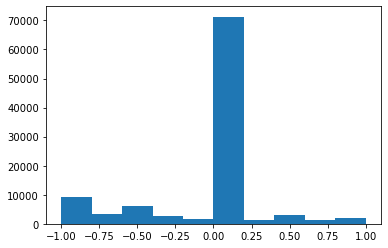

In [8]:
import matplotlib.pyplot as plt

values=[]
for i in policyMapMQL.values():
    values.extend(list(i.values()))
plt.hist(values)
plt.show()

In [9]:
values = []
positives = 0
negatives = 0
zeros = 0
for i in policyMapMQL.values():
    values.extend(list(i.values()))
for i in values:
    if i > 0:
        positives += 1
    else:
        if i < 0:
            negatives += 1
        else:
            zeros += 1
            
print("Positives:", positives, ", Negatives:", negatives, "Zeros:", zeros)
# Positives: 8391 , Negatives: 22705 Zeros: 70406
# Positives: 2453 , Negatives: 8164 Zeros: 26689
# Positives: 3228 , Negatives: 9583 Zeros: 31323
# Positives: 4254 , Negatives: 11108 Zeros: 37044

Positives: 8391 , Negatives: 22705 Zeros: 70406


Load list of rewards

In [3]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
rewards_list_minimax_ql = []

# open file and read the content in a list
with open('rewards_list_minimax_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        rewards_list_minimax_ql.append(int(currentPlace))

In [10]:
len(rewards_list_minimax_ql)

200000

In [5]:
import numpy as np
import datetime

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

num_cols = env.configuration.columns

# Training agent in first position (player 1) against the negamax agent.
trainer = env.train([None, "negamax"])

discount = 0.9
epsilon = 0.99 # parameter for epsilon-greedy policy
# epsilon = 0.2 # parameter for epsilon-greedy policy
alpha = 0.5 # learning rate
t_max = 1000 # used for environments without end
total_reward = 0 # used for displaying the evolution of the rewards as the model learns

def get_best_action(board, num_cols, policy, function):
    """
    Returns the action with maximum q-value or minimum q-value depending on the needs
    function parameter should be "max" or "min"
    """
    # function parameter validation
    if (function != "max" and function != "min"):
        print("Parameter function should be ""max"" or ""min""")
        return -1
    
    # greedy policy
    if (function == "max"):
        best_q_value = float("-inf")
    else:
        best_q_value = float("inf")
    best_action = None
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    for col in available_cols:
        q_value = policy.get(board_key,dict()).get(col,0)
        if (function == "max" and q_value > best_q_value and q_value != 0):
        # Condition q_value != 0 allows rewards to propagate to the initial states. Without this condition we usually take unexplored actions (with q_value==0),
        # instead of explored ones (with q_value<0), as we are taking the maximum. Then, negative rewards didn't "reach" the initial states
            best_action = col
            best_q_value = q_value
        else:
            if (function == "min" and q_value < best_q_value and q_value != 0):
            # Condition q_value != 0 allows rewards to propagate to the initial states. Without this condition we usually take unexplored actions (with q_value==0),
            # instead of explored ones (with q_value>0), as we are taking the minimum. Then, positive rewards didn't "reach" the initial states
                best_action = col
                best_q_value = q_value
                
        # If every q_value is zero, select randomly one action
        if (best_action == None):
            best_action = int(np.random.choice(available_cols))
            best_q_value = 0
            
    return best_action

def get_action(board, num_cols, epsilon, policy):
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        return get_best_action(board, num_cols, policy, "max")
    else:
        # random
        return int(np.random.choice(available_cols))

t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(50000):
    done = False
    t = 0
    #env.render()
    while not done and t < t_max:
        # Convert board in a tuple to use it as the key in a dict structure
        board_key = tuple(obs.board)
        action = get_action(obs.board, num_cols, epsilon, policyMapMQL)
        obs, reward, done, info = trainer.step(action)
        # Each step usually includes two steps (my movement and opponent's movement), so I need to update the policy for both of them (I can play as player 1 or 2)
        # If my movement is a winning one, there is only one step
        # Update policy (player1). Q(s,a) = (1 - alpha) * Q(s,a) + alpha * (r + gamma * max(Q(s',a')))
        # Update policy (player2). Q(s,a) = (1 - alpha) * Q(s,a) + alpha * (r + gamma * min(Q(s',a')))
        
        # If my movement IS NOT a wining movement, we will have two steps
        if not(done and reward==1):
            # Update policy with my movement: My board - board_key, My action - action, My board after action - env.steps[-2][0]["observation"]["board"]
            board_step1_key = board_key
            action_step1 = action
            reward_step1 = env.steps[-2][0]["reward"]
            new_board_step1 = env.steps[-2][0]["observation"]["board"]
            new_board_step1_key = tuple(new_board_step1)
            # Next action is for player 2, and its best action is the one with the minimum q_value
            new_action_step1 = get_best_action(new_board_step1, num_cols, policyMapMQL, "min")
            policyMapMQL[board_step1_key][action_step1] = ((1 - alpha) * policyMapMQL[board_step1_key][action_step1]
                                                          + alpha * (reward_step1 + discount * policyMapMQL[new_board_step1_key][new_action_step1]))
            
            # Update policy with opponent's movement: board - env.steps[-2][0]["observation"]["board"], action - env.steps[-1][1]["action"], board after action - obs.board
            board_step2_key = new_board_step1_key
            action_step2 = env.steps[-1][1]["action"]
            reward_step2 = reward
            new_board_step2 = obs.board
            new_board_step2_key = tuple(new_board_step2)
            # Next action is for player 1, and its best action is the one with the maximum q_value
            new_action_step2 = get_best_action(new_board_step2, num_cols, policyMapMQL, "max")
            policyMapMQL[board_step2_key][action_step2] = ((1 - alpha) * policyMapMQL[board_step2_key][action_step2]
                                                          + alpha * (reward + discount * policyMapMQL[new_board_step2_key][new_action_step2]))
        # If my movement IS a wining movement, we will have only one step
        else:
            # Q-value of (winning_board, state) makes no sense because the game is over, so we simplify the expression
            policyMapMQL[board_key][action] = ((1 - alpha) * policyMapMQL[board_key][action]) + alpha * reward
            
        total_reward += reward
            
        t += 1

    rewards_list_minimax_ql.append(total_reward)
    total_reward = 0
        
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    epsilon *= 0.99999
    obs = trainer.reset()
            
    if (i % 10000) == 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000
# 23:20:41
# 23:58:51
# 50000
# 23:10:25
# 00:15:59
# 50000
# 00:23:06
# 01:30:21
# 50000
# 20:10:54
# 21:19:42

Loading environment football failed: No module named 'gfootball'
Inicio 20:10:54
0 20:10:54
10000 20:24:32
20000 20:38:44
30000 20:52:17
40000 21:05:54
Fin 21:19:42


In [11]:
import numpy as np


np.unique(rewards_list_minimax_ql, return_counts=True)

(array([-1,  1]), array([175480,  24520], dtype=int64))

Minimax Q-Learning mean reward = -0.58


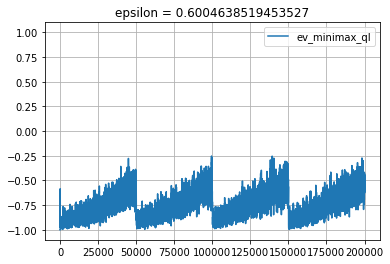

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(rewards_list_minimax_ql[i:i+n])/n for i in range(0,len(rewards_list_minimax_ql)-n+1)]

clear_output(True)
print('Minimax Q-Learning mean reward =', np.mean(rewards_list_minimax_ql[-1000:]))
plt.title("epsilon = %s" % epsilon)
#plt.plot(rewards_list_minimax_ql, label='ev_sarsa')
plt.plot(moving_average(rewards_list_minimax_ql), label='ev_minimax_ql')
#plt.plot(moving_average2, label='ev_sarsa2')
plt.grid()
plt.legend()
plt.ylim(-1.1, 1.1)
plt.show()

# Minimax Q-Learning mean reward = -0.6 (eps=0.60046)
# Minimax Q-Learning mean reward = -0.538 (eps=0.60046)
# Minimax Q-Learning mean reward = -0.558 (eps=0.60046)
# Minimax Q-Learning mean reward = -0.58 (eps=0.60046)

In [ ]:
np.mean(rewards_list_minimax_ql[-1000:])

Save policyMap to a file

In [13]:
policyMapMQL_dict = dict(policyMapMQL)
policyMapMQL_dict = {k: dict(v) for k, v in policyMapMQL_dict.items()}

with open(r'policyMapMQL.dict','w+') as f:
     f.write(str(policyMapMQL_dict))

Save list of rewards

In [14]:
with open(r'rewards_list_minimax_ql.txt','w+') as f:
    for element in rewards_list_minimax_ql:
        f.write(str(element) + '\n')

Define the agent as a function, so that we can use it with Kaggle environment

In [26]:
import numpy as np

from collections import defaultdict

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_MQL(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the policiMap from file
    dic = ''
    with open(r'policyMapMQL.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapMQL_dict = eval(dic)
    policyMapMQL = defaultdict(lambda: defaultdict(lambda: 0), policyMapMQL_dict)
    for k, v in policyMapMQL.items():
        policyMapMQL[k] = defaultdict(lambda: 0, v)
    
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    #board_array=np.array(board)
    #board_array=board_array.reshape((num_rows,num_cols))
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list=[] # List with rewards of each movement
    for target_col in available_cols:
        target_board = board.copy()
        target_index = first_row_avail(board, target_col, num_rows, num_cols)
        #target_board[target_index] = mark
        # Convert target_board into a tuple so that we can use it as a key for the policyMap
        board_key = tuple(target_board)
        reward = policyMapMQL[board_key][target_col]
        reward_list.append(reward)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Get the highest reward if the agent is player 1 and the lowest if is player 2. The policy has been learned with player 1
    if mark == 1:
        max_reward = max(reward_list)
    else:
        #max_reward = min(reward_list)
        # Choose only columns with non-zero reward, because zero reward means unknown states, and the agent plays randomly in these cases
        # If every non-zero value is close to 1 (means losing the game), it's better to take a chance with zero values
        max_reward = min([value for value in reward_list if value!=0 and value<0.98], default=0)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [i for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    return available_cols[int(np.random.choice(max_rewards_index))]

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_MQL, "negamax"])
#env.run(["negamax", agent_MQL])
#env.run(["random", agent_MQL])
#env.render(mode="ipython", width=500, height=450)
#env.state


In [ ]:
num_fichas = [1, 2, 3, 5, 7]

for i in num_fichas:
    positives = 0
    negatives = 0
    zeros = 0
    num_tableros = 0
    for k, v in policyMapMQL.items():
        if (sum([i != 0 for i in k])) == i:
            num_tableros += 1
            if (i <= 2):
                print("Num. fichas:", i, " Tablero:", k)
            for v1 in v.values():
                if (v1 > 0):
                    positives += 1
                else:
                    if (v1 < 0):
                        negatives += 1
                    else:
                        zeros += 1

    print("Num. fichas:", i, " Num. tableros:", num_tableros, " Positives:", positives, ", Negatives:", negatives, "Zeros:", zeros)
    
# Con eps fijo (0,2)
# Num. fichas: 1  Num. tableros: 5  Positives: 8 , Negatives: 0 Zeros: 17
# Num. fichas: 2  Num. tableros: 8  Positives: 18 , Negatives: 22 Zeros: 0
# Num. fichas: 3  Num. tableros: 37  Positives: 33 , Negatives: 34 Zeros: 114
# Num. fichas: 5  Num. tableros: 258  Positives: 66 , Negatives: 289 Zeros: 597
# Num. fichas: 7  Num. tableros: 1120  Positives: 343 , Negatives: 867 Zeros: 1990

# Con eps variable (0,99999 --> 0,6)
# Num. fichas: 1  Num. tableros: 5  Positives: 8 , Negatives: 0 Zeros: 17
# Num. fichas: 2  Num. tableros: 8  Positives: 22 , Negatives: 18 Zeros: 0
# Num. fichas: 3  Num. tableros: 37  Positives: 37 , Negatives: 30 Zeros: 110
# Num. fichas: 5  Num. tableros: 258  Positives: 117 , Negatives: 278 Zeros: 592
# Num. fichas: 7  Num. tableros: 1216  Positives: 502 , Negatives: 1186 Zeros: 2155

In [19]:
par=0
impar=0
for k in policyMapMQL.keys():
    if (sum([i != 0 for i in k]) % 2) == 0:
        par += 1
    else:
        impar += 1
par, impar

(22207, 19342)

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [20]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", ["random", agent_MQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
#evaluate("connectx", [agent, "negamax"], num_episodes=10)

[[-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [1, -1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [1, -1]]

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [3]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_MQL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_MQL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_MQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_MQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

My Agent vs Random Agent: 0.2
My Agent vs Negamax Agent: 1.0
Random Agent vs My Agent: -0.8
Negamax Agent vs My Agent: 0.4


In [6]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC, agent_QL, agent_SA, agent_ESA, agent_MQL]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<10} {:<6}".format('Position','Agent','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<10} {:>6.2f}".format(i+1, result[0], result[1]))

# Con eps fijo (0,2)
# Position   Team       Points
# 1          agent_MC     3.60
# 2          negamax      2.20
# 3          agent_SA     1.20
# 4          agent_QL     0.80
# 5          agent_MQL   -0.40
# 6          agent_ESA   -1.00
# 7          random      -6.40

# Con eps variable (0,99999 --> 0,60)
# Position   Agent      Points
# 1          negamax      2.20
# 2          agent_MC     1.40
# 3          agent_MQL    1.20
# 4          agent_QL     0.80
# 5          agent_ESA    0.60
# 6          agent_SA     0.20
# 7          random      -6.40


Playing random vs negamax
-0.4
Playing random vs agent_MC
-1.0
Playing random vs agent_QL
-0.2
Playing random vs agent_SA
0.0
Playing random vs agent_ESA
-0.2
Playing random vs agent_MQL
-1.0
Playing negamax vs random
1.0
Playing negamax vs agent_MC
1.0
Playing negamax vs agent_QL
1.0
Playing negamax vs agent_SA
0.8
Playing negamax vs agent_ESA
1.0
Playing negamax vs agent_MQL
0.6
Playing agent_MC vs random
0.6
Playing agent_MC vs negamax
1.0
Playing agent_MC vs agent_QL
1.0
Playing agent_MC vs agent_SA
0.4
Playing agent_MC vs agent_ESA
1.0
Playing agent_MC vs agent_MQL
1.0
Playing agent_QL vs random
0.4
Playing agent_QL vs negamax
1.0
Playing agent_QL vs agent_MC
1.0
Playing agent_QL vs agent_SA
1.0
Playing agent_QL vs agent_ESA
1.0
Playing agent_QL vs agent_MQL
1.0
Playing agent_SA vs random
0.8
Playing agent_SA vs negamax
0.4
Playing agent_SA vs agent_MC
0.6
Playing agent_SA vs agent_QL
0.8
Playing agent_SA vs agent_ESA
0.8
Playing agent_SA vs agent_MQL
0.2
Playing agent_ESA vs rand

#### Temporal Differece Double Q-learning  
Unlike MonteCarlo, in this algorithm we try to get Q-values (value for pair state, action) and we don't need the full episode to learn (bootstrapping).  
As Q-learning, this is an off-policy method.  
Off Policy. Learn policy $ \pi $ (greedy) using policy $ \mu $ (epsilon-greedy: greedy or random depending on a random value)  
Unlike Q-learning, it uses 2 Q-value tables, one for selecting the next best action, and the other one for evaluating it to update q-values. With 2 Q-value tables we try to avoid overestimation and underestimation.  

In [ ]:
from collections import defaultdict


# Nested dictionary. We use defaultdict because it avoids issues with unexisting keys.
policyMapDQL_1 = defaultdict(lambda: defaultdict(lambda: 0))
policyMapDQL_2 = defaultdict(lambda: defaultdict(lambda: 0))

rewards_list_double_ql = []

In [ ]:
# https://www.peterbe.com/plog/be-careful-with-using-dict-to-create-a-copy
# https://stackoverflow.com/questions/22389989/python-copying-or-cloning-a-defaultdict-variable
from copy import deepcopy


policyMapDQL_AAA = deepcopy(policyMapDQL_1)

In [ ]:
id(policyMapDQL_1), id(policyMapDQL_AA)

In [ ]:
id(policyMapDQL_1[(0,0)]), id(policyMapDQL_AA[(0,0)])

Load policyMap from a file

In [4]:
from collections import defaultdict


dic = ''
with open(r'policyMapDQL_1.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapDQL_dict = eval(dic)
policyMapDQL_1 = defaultdict(lambda: defaultdict(lambda: 0), policyMapDQL_dict)
for k, v in policyMapDQL_1.items():
    policyMapDQL_1[k] = defaultdict(lambda: 0, v)

dic = ''
with open(r'policyMapDQL_2.dict','r') as f:
         for i in f.readlines():
            dic=i #string
policyMapDQL_dict = eval(dic)
policyMapDQL_2 = defaultdict(lambda: defaultdict(lambda: 0), policyMapDQL_dict)
for k, v in policyMapDQL_2.items():
    policyMapDQL_2[k] = defaultdict(lambda: 0, v)


In [2]:
len(policyMapDQL_1.keys()), len(policyMapDQL_2.keys())
# (5306, 5264)
# (7035, 7008)
# (7958, 7949)
# (8939, 8956)

(8939, 8956)

In [3]:
min([min(i.values()) for i in policyMapDQL_1.values()]), max([max(i.values()) for i in policyMapDQL_1.values()]), min([min(i.values()) for i in policyMapDQL_2.values()]), max([max(i.values()) for i in policyMapDQL_2.values()])

(-1.0, 1.0, -1.0, 1.0)

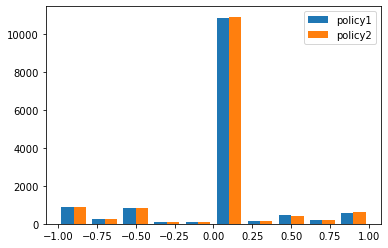

In [4]:
import matplotlib.pyplot as plt

# MIRAR SI SE PUEDE HACER SOLO EN 1!!!

values_1=[]
for i in policyMapDQL_1.values():
    values_1.extend(list(i.values()))

values_2=[]
for i in policyMapDQL_2.values():
    values_2.extend(list(i.values()))

plt.hist([values_1,values_2], label=['policy1','policy2'])
plt.legend(loc='upper right')
plt.show()


Load list of rewards

In [2]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
rewards_list_double_ql = []

# open file and read the content in a list
with open('rewards_list_double_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        rewards_list_double_ql.append(int(currentPlace))

In [ ]:
len(rewards_list_double_ql)

In [ ]:
# https://towardsdatascience.com/double-q-learning-the-easy-way-a924c4085ec3
# https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
# Based in the Hado van Hasselt's paper: https://proceedings.neurips.cc/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf

import numpy as np
import datetime

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

num_cols = env.configuration.columns

# Training agent in first position (player 1) against the negamax agent.
trainer = env.train([None, "negamax"])

discount = 0.9
epsilon = 0.20 # parameter for epsilon-greedy policy
alpha = 0.5 # learning rate
t_max = 1000 # used for environments without end
total_reward = 0 # used for displaying the evolution of the rewards as the model learns

def get_best_action(board, num_cols, policy):
    # greedy policy
    q_value_max = float("-inf")
    best_action = None
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    for col in available_cols:
        q_value = policy.get(board_key,dict()).get(col,0)
        if q_value > q_value_max:
            best_action = col
            q_value_max = q_value
    return best_action

def get_best_action_combined(board, num_cols, policyA, policyB):
    """
    Returns the best action using the addition of policyA and policyB.
    """
    # greedy policy
    q_value_max = float("-inf")
    best_action = None
    # Convert board in a tuple to use it as the key in a dict structure
    board_key = tuple(board)
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    for col in available_cols:
        q_value = policyA.get(board_key,dict()).get(col,0) + policyB.get(board_key,dict()).get(col,0)
        if q_value > q_value_max:
            best_action = col
            q_value_max = q_value
    return best_action

def get_action_combined(board, num_cols, epsilon, policyA, policyB):
    """
    Returns the action using an epsilon-greedy policy. When returning the best action, it combines policyA and policyB
    """
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        return get_best_action_combined(board, num_cols, policyA, policyB)
    else:
        # random
        return int(np.random.choice(available_cols))


t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(50000):
    done = False
    t = 0
    #env.render()
    while not done and t < t_max:
        # Convert board in a tuple to use it as the key in a dict structure
        board_key = tuple(obs.board)
        # Select the action with epsilon-greedy using policyA + policyB
        action = get_action_combined(obs.board, num_cols, epsilon, policyMapDQL_1, policyMapDQL_2)
        obs, reward, done, info = trainer.step(action)
        # Select randomly policy to get next action and policy to update
        # With policy_X = policy_Y we are just copying the reference. Both dicts will point to the same place in memory.
        # So every change in policy_X will be also in policy_Y and vice versa. If we want to clone the nested dict, we need deepcopy
        if (np.random.random() > 0.5):
            policyA = policyMapDQL_1
            policyB = policyMapDQL_2
        else:
            policyA = policyMapDQL_2
            policyB = policyMapDQL_1
        
        # Each step usually includes two steps (my movement and opponent's movement), so I need to update the policy for both of them (I can play as player 1 or 2)
        # If my movement is a winning one, there is only one step
        # Update policy. Q(s,a) = (1 - alpha) * Q(s,a) + alpha * (r + gamma * max(Q(s',a')))
        
        # If my movement IS NOT a wining movement, we will have two steps
        if not(done and reward==1):
            # Update policy with my movement: My board - board_key, My action - action, My board after action - env.steps[-2][0]["observation"]["board"]
            board_step1_key = board_key
            action_step1 = action
            reward_step1 = env.steps[-2][0]["reward"]
            new_board_step1 = env.steps[-2][0]["observation"]["board"]
            new_board_step1_key = tuple(new_board_step1)
            new_action_step1 = get_best_action(new_board_step1, num_cols, policyA)
            # Select action using policyA, and update using q-values of policyB
            policyA[board_step1_key][action_step1] = ((1 - alpha) * policyA[board_step1_key][action_step1]
                                                      + alpha * (reward_step1 + discount * policyB[new_board_step1_key][new_action_step1]))
            
            # Update policy with opponent's movement: board - env.steps[-2][0]["observation"]["board"], action - env.steps[-1][1]["action"], board after action - obs.board
            board_step2_key = new_board_step1_key
            action_step2 = env.steps[-1][1]["action"]
            reward_step2 = reward
            new_board_step2 = obs.board
            new_board_step2_key = tuple(new_board_step2)
            new_action_step2 = get_best_action(new_board_step2, num_cols, policyA)
            # Select action using policyA, and update using q-values of policyB
            policyA[board_step2_key][action_step2] = ((1 - alpha) * policyA[board_step2_key][action_step2]
                                                      + alpha * (reward + discount * policyB[new_board_step2_key][new_action_step2]))
        # If my movement IS a wining movement, we will have only one step
        else:
            # Q-value of (winning_board, state) makes no sense because the game is over, so we simplify the expression
            policyA[board_key][action] = ((1 - alpha) * policyA[board_key][action]) + alpha * reward
            
        total_reward += reward
            
        t += 1
        
    rewards_list_double_ql.append(total_reward)
    total_reward = 0
    
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    #epsilon *= 0.99999
    obs = trainer.reset()
            
    if (i % 10000) == 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000
# 15:19:37
# 16:01:19
# 50000
# 16:55:27
# 18:37:47
# 50000
# 22:54:12
# 00:51:53
# 50000
# 15:39:45
# 16:26:16

In [ ]:
import numpy as np


np.unique(rewards_list_double_ql, return_counts=True)
# (array([-1,  1]), array([37645, 12355], dtype=int64))
# (array([-1,  1]), array([60768, 39232], dtype=int64))
# (array([-1,  1]), array([83792, 66208], dtype=int64))
# (array([-1,  1]), array([106606,  93394], dtype=int64))

Double Q-Learning mean reward = 0.03


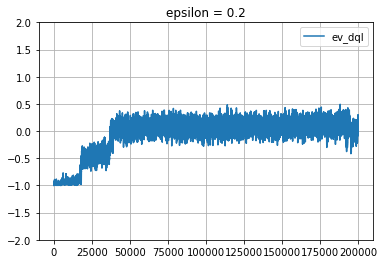

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from pandas import DataFrame


epsilon = 0.20
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(rewards_list_double_ql[i:i+n])/n for i in range(0,len(rewards_list_double_ql)-n+1)]

clear_output(True)
print('Double Q-Learning mean reward =', np.mean(rewards_list_double_ql[-1000:]))
plt.title("epsilon = %s" % epsilon)
#plt.plot(rewards_list_double_ql, label='ev_sarsa')
plt.plot(moving_average(rewards_list_double_ql), label='ev_dql')
#plt.plot(moving_average2, label='ev_sarsa2')
plt.grid()
plt.legend()
plt.ylim(-2, 2)
plt.show()

# Double Q-Learning mean reward = 0.012
# Double Q-Learning mean reward = 0.09
# Double Q-Learning mean reward = 0.094
# Double Q-Learning mean reward = 0.03

In [ ]:
np.mean(rewards_list_double_ql[-1000:])

Save policyMap to a file

In [ ]:
policyMapDQL_dict = dict(policyMapDQL_1)
policyMapDQL_dict = {k: dict(v) for k, v in policyMapDQL_dict.items()}

with open(r'policyMapDQL_1.dict','w+') as f:
     f.write(str(policyMapDQL_dict))
        
policyMapDQL_dict = dict(policyMapDQL_2)
policyMapDQL_dict = {k: dict(v) for k, v in policyMapDQL_dict.items()}

with open(r'policyMapDQL_2.dict','w+') as f:
     f.write(str(policyMapDQL_dict))

Save list of rewards

In [ ]:
with open(r'rewards_list_double_ql.txt','w+') as f:
    for element in rewards_list_double_ql:
        f.write(str(element) + '\n')

Define the agent as a function, so that we can use it with Kaggle environment

In [41]:
import numpy as np

from collections import defaultdict

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_DQL(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the policiMaps from files
    dic = ''
    with open(r'policyMapDQL_1.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapDQL_dict = eval(dic)
    policyMapDQL_1 = defaultdict(lambda: defaultdict(lambda: 0), policyMapDQL_dict)
    for k, v in policyMapDQL_1.items():
        policyMapDQL_1[k] = defaultdict(lambda: 0, v)

    dic = ''
    with open(r'policyMapDQL_2.dict','r') as f:
        for i in f.readlines():
            dic=i #string
    policyMapDQL_dict = eval(dic)
    policyMapDQL_2 = defaultdict(lambda: defaultdict(lambda: 0), policyMapDQL_dict)
    for k, v in policyMapDQL_2.items():
        policyMapDQL_2[k] = defaultdict(lambda: 0, v)

    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    #board_array=np.array(board)
    #board_array=board_array.reshape((num_rows,num_cols))
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list=[] # List with rewards of each movement
    for target_col in available_cols:
        target_board = board.copy()
        target_index = first_row_avail(board, target_col, num_rows, num_cols)
        # Convert target_board into a tuple so that we can use it as a key for the policyMap
        board_key = tuple(target_board)
        reward = policyMapDQL_1[board_key][target_col] + policyMapDQL_2[board_key][target_col]
        reward_list.append(reward)
        print("Column:"+str(target_col)+" Reward:"+str(reward)+" Reward_1:"+str(policyMapDQL_1[board_key][target_col])+" Reward_2:"+str(policyMapDQL_2[board_key][target_col]))
    # Get the highest reward if the agent is player 1 and the lowest if is player 2. The policy has been learned with player 1
    if mark == 1:
        max_reward = max(reward_list)
    else:
        # Choose only columns with non-zero reward, because zero reward means unknown states, and the agent plays randomly in these cases
        # If every non-zero value is close to 1 (means losing the game), it's better to take a chance with zero values
        max_reward = min([value for value in reward_list if value!=0 and value<1.98], default=0)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [i for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    return available_cols[int(np.random.choice(max_rewards_index))]
        
# Run an episode using the agent above vs the negamax agent.
#env.run([agent_DQL, "negamax"])
#env.run(["negamax", agent_DQL])
#env.run(["random", agent_DQL])
#env.render(mode="ipython", width=500, height=450)
#env.state


In [ ]:
num_fichas = [1, 2, 3, 5, 7]

for i in num_fichas:
    positives = 0
    negatives = 0
    zeros = 0
    num_tableros = 0
    for k, v in policyMapDQL_1.items():
        if (sum([i != 0 for i in k])) == i:
            num_tableros += 1
            if (i <= 2):
                print("Num. fichas:", i, " Tablero:", k)
            for v1 in v.values():
                if (v1 > 0):
                    positives += 1
                else:
                    if (v1 < 0):
                        negatives += 1
                    else:
                        zeros += 1

    print("Num. fichas:", i, " Num. tableros:", num_tableros, " Positives:", positives, ", Negatives:", negatives, "Zeros:", zeros)
    
# Con eps fijo (0,2)
# Num. fichas: 1  Num. tableros: 5  Positives: 7 , Negatives: 0 Zeros: 5
# Num. fichas: 2  Num. tableros: 8  Positives: 15 , Negatives: 0 Zeros: 25
# Num. fichas: 3  Num. tableros: 37  Positives: 16 , Negatives: 0 Zeros: 76
# Num. fichas: 5  Num. tableros: 252  Positives: 17 , Negatives: 82 Zeros: 464
# Num. fichas: 7  Num. tableros: 828  Positives: 112 , Negatives: 380 Zeros: 1020

In [ ]:
# Both policies seems to have the same values. Let's check it
i = 0
for k1, v1 in policyMapDQL_1.items():
    for k2, v2 in v1.items():
        if abs(policyMapDQL_2[k1][k2] - v2) > 0.1:
            print("Key1:"+str(k1)+" Key2:"+str(k2)+" Value_pol1:"+str(v2)+" Value_pol2:"+str(policyMapDQL_2[k1][k2]))
            i += 1

print("Total: "+str(i))

# 2239

In [ ]:
# Both policies seems to have the same values. Let's check it
i = 0
for k1, v1 in policyMapDQL_2.items():
    for k2, v2 in v1.items():
        if abs(policyMapDQL_1[k1][k2] - v2) > 0.1:
            print("Key1:"+str(k1)+" Key2:"+str(k2)+" Value_pol1:"+str(v2)+" Value_pol2:"+str(policyMapDQL_1[k1][k2]))
            i += 1

print("Total: "+str(i))

# 2850

In [ ]:
par=0
impar=0
for k in policyMapDQL.keys():
    if (sum([i != 0 for i in k]) % 2) == 0:
        par += 1
    else:
        impar += 1
par, impar

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [ ]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_MC, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", ["random", agent_DQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10, debug=True)
#evaluate("connectx", [agent, "negamax"], num_episodes=10)

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [ ]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_DQL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_DQL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_DQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_DQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

In [13]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC, agent_QL, agent_SA, agent_ESA, agent_MQL, agent_DQL]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

#print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<10} {:<6}".format('Position','Team','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<10} {:>6.2f}".format(i+1, result[0], result[1]))


Playing random vs negamax
-0.8
Playing random vs agent_MC
-1.0
Playing random vs agent_QL
-0.4
Playing random vs agent_SA
-0.6
Playing random vs agent_ESA
-0.6
Playing random vs agent_MQL
-0.8
Playing random vs agent_DQL
0.4
Playing negamax vs random
1.0
Playing negamax vs agent_MC
1.0
Playing negamax vs agent_QL
1.0
Playing negamax vs agent_SA
1.0
Playing negamax vs agent_ESA
1.0
Playing negamax vs agent_MQL
0.4
Playing negamax vs agent_DQL
1.0
Playing agent_MC vs random
1.0
Playing agent_MC vs negamax
1.0
Playing agent_MC vs agent_QL
1.0
Playing agent_MC vs agent_SA
1.0
Playing agent_MC vs agent_ESA
1.0
Playing agent_MC vs agent_MQL
1.0
Playing agent_MC vs agent_DQL
0.6
Playing agent_QL vs random
0.2
Playing agent_QL vs negamax
1.0
Playing agent_QL vs agent_MC
1.0
Playing agent_QL vs agent_SA
0.8
Playing agent_QL vs agent_ESA
1.0
Playing agent_QL vs agent_MQL
1.0
Playing agent_QL vs agent_DQL
0.4
Playing agent_SA vs random
0.8
Playing agent_SA vs negamax
0.2
Playing agent_SA vs agent

#### Temporal Differece Deep Q-learning  
Unlike regular Q-learning, in this algorithm we use a neural network to estimate the Q-values of a state.  
Off Policy. Learn policy $ \pi $ (greedy) using policy $ \mu $ (epsilon-greedy: greedy or random depending on a random value)  

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


rewards_list_deep_ql = []

ERROR! Session/line number was not unique in database. History logging moved to new session 657


Create model

In [22]:
# RED v2
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

model = Sequential()
model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(num_rows, num_cols, 1))) # padding=valid # Input: (5, 5, 1) Output (3, 3, 8)
model.add(Flatten()) # Input: (3, 3, 8) Output: (72)
model.add(Dense(8, activation='relu')) # Input: (72) Output: (8)
model.add(Dense(action_size, activation="linear")) # Input: (8) Output: (5)
model.compile(Adam(lr=0.01), loss='mse')


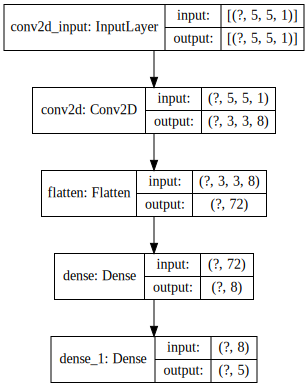

In [7]:
from IPython.display import SVG, display, clear_output
from tensorflow.keras.utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 3, 8)           80        
_________________________________________________________________
flatten_2 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 584       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________


Load model from a file

In [1]:
model = tf.keras.models.load_model('model_DQN.h5')

Load list of rewards

In [1]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
rewards_list_deep_ql = []

# open file and read the content in a list
with open('rewards_list_deep_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        rewards_list_deep_ql.append(int(currentPlace))

In [2]:
len(rewards_list_deep_ql)

100000

Load list of loss

In [3]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
accum_train_loss = []

# open file and read the content in a list
with open('loss_list_deep_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        #accum_train_loss.append(int(currentPlace))
        accum_train_loss.append(float(currentPlace))
        
accum_train_loss_2 = []

# open file and read the content in a list
with open('loss_2_list_deep_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        accum_train_loss_2.append(float(currentPlace))

In [4]:
len(accum_train_loss), len(accum_train_loss_2)

(99872, 6391808)

Callbacks

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint


modelpath="model_DQN_callback.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='loss', verbose=0,
                             save_best_only=True,
                             mode='min') # graba sólo los que mejoran en la función de pérdida
callbacks_list = [checkpoint]

Agent

In [21]:
import numpy as np
import random
import datetime

from kaggle_environments import make
from collections import deque

#import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

action_size = env.configuration.columns
num_cols = env.configuration.columns
num_rows = env.configuration.rows
state_size = env.configuration.columns * env.configuration.rows

# Training agent in first position (player 1) against the negamax/random agent.
#trainer = env.train([None, "negamax"])
trainer = env.train([None, "random"])

discount = 0.9
#epsilon = 0.99 # parameter for epsilon-greedy policy
#epsilon = 0.01 # parameter for epsilon-greedy policy
epsilon = 0.22089720180217606 # parameter for epsilon-greedy policy
epsilon_min = 0.05 # epsilon is decreasing but we avoid it to be smaller than epsilon_min
t_max = 1000 # used for environments without end
total_reward = 0 # used for displaying the evolution of the rewards as the model learns
memory = deque(maxlen=10000)
batch_size = 128
accum_train_loss_2 = []
last_n_steps = 2
num_episodes = 50000

#new_model = True
new_model = False
# Create/Load model
if new_model:
    model = Sequential()
    model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(num_rows, num_cols, 1))) # padding=valid # Input: (5, 5, 1) Output: (3, 3, 8)
    model.add(Flatten()) # Input: (3, 3, 8) Output: (72)
    model.add(Dense(8, activation='relu')) # Input: (72) Output: (8)
    model.add(Dense(action_size, activation="linear")) # Input: (8) Output: (5)
    model.compile(Adam(lr=0.01), loss='mse')
    accum_train_loss = []
    rewards_list_deep_ql = []
    accum_train_loss_2 = []
else:
    model = load_model('model_DQN.h5')

def get_best_action(board, num_cols, model, function):
    """
    Returns the action with maximum q-value or minimum q-value depending on the needs. This will be done only in available columns
    Parameter "function" should be "max" or "min"
    """
    # function parameter validation
    if (function != "max" and function != "min"):
        print("Parameter function should be ""max"" or ""min""")
        return -1
    
    # greedy policy
    if (function == "max"):
        best_q_value = float("-inf")
    else:
        best_q_value = float("inf")
    
    # Search the best q-value but only in available columns (we cannot use np.argmax)
    best_action = None
    rewards = model(board).numpy()[0]
    available_cols = [col for col in range(num_cols) if board[0][0][col] == 0]
    for col in available_cols:
        q_value = rewards[col]
        if (function == "max" and q_value > best_q_value):
            best_action = col
            best_q_value = q_value
        else:
            if (function == "min" and q_value < best_q_value):
                best_action = col
                best_q_value = q_value
                
    return best_action

def get_action(board, num_cols, epsilon, model):
    available_cols = [col for col in range(num_cols) if board[0][0][col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        # We need to search best value, but only in available columns, so we cannot use np.argmax
        return get_best_action(board, num_cols, model, "max")
    else:
        # random
        return int(np.random.choice(available_cols))

def convert_for_CNN(board, num_rows, num_cols):
    """
    Converts the board (list) into a matrix of shape (rows, cols, 1), so that a CNN can work with it.
    Player 2 checkers are replaced to -1
    """
    board = [np.float32(-1) if x==2 else np.float32(x) for x in board]
    return np.reshape(board, [1, num_rows, num_cols, 1])
    
    
t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(num_episodes):
    done = False
    t = 0
    while not done and t < t_max:
        # Convert board in a matrix to use it as the neural network input
        board_matrix = convert_for_CNN(obs.board, num_rows, num_cols) #np.reshape(obs.board, [1, state_size])
        action = get_action(board_matrix, num_cols, epsilon, model)
        obs, reward, done, info = trainer.step(action)
        total_reward += reward
        
        t += 1

    # Train at the end of each episode
    
    # Add to the experience replay only the last n steps of the episode (all of them as player 1)
    num_steps = env.steps[-1][0]["observation"]["step"]
    last_reward = env.steps[-1][0]["reward"]
    for j in range(1, num_steps + 1):
        state = convert_for_CNN(env.steps[j-1][0]["observation"]["board"], num_rows, num_cols)
        next_state = convert_for_CNN(env.steps[j][0]["observation"]["board"], num_rows, num_cols)
        done = (env.steps[j][0]["status"] == 'DONE')
        # REWARD SHAPING --> As we only have reward at the end of the episode, we generate partial rewards
        if done:
            reward = last_reward * 2
        else:
            reward = (0.5 ** (num_steps - j)) * last_reward
        if env.steps[j-1][0]["status"] == 'ACTIVE':
            # Player 1
            action = env.steps[j][0]["action"]
        else:
            # Player 2 --> Convert player 2 movements into player one's
            action = env.steps[j][1]["action"]
            # Convert player 2 boards to player 1's
            state = (state * (-1)) + 0 # +0 to avoid negative zeros
            next_state = (next_state * (-1)) + 0 # +0 to avoid negative zeros
            reward = reward *(-1) + 0
        player = 1
        if (j > num_steps - last_n_steps):
            memory.append((state, action, reward, next_state, player, done))

    # Extract a minibatch from the experience replay and train the neural network
    if len(memory) > batch_size:
        minibatch = random.sample(memory, batch_size)
            
        X_states = np.empty(shape=(batch_size, num_rows, num_cols, 1))
        y_targets = np.empty(shape=(batch_size, action_size))
            
        for j, (state_batch, action_batch, reward_batch, next_state_batch, player_batch, done_batch) in enumerate(minibatch):
            X_states[j] = state_batch[0]
            # If it's an ending state, just update the target with the reward. If not, update target using Bellman optimality equation for Q-values
            if not done:
                target_updated = (reward_batch + discount*np.amax(model(next_state_batch).numpy()[0]))
            else:
                target_updated = reward_batch
                
            targets = model(state_batch).numpy()
            #print("Target obtenida:", targets[0][action_batch], "Target objetivo:", target_updated)
            loss = abs(target_updated - targets[0][action_batch])
            accum_train_loss_2.append(loss)
            targets[0][action_batch] = target_updated
            y_targets[j] = targets[0]
            
        # Train the model with these new targets
        history = model.fit(X_states, y_targets, epochs=1, callbacks=callbacks_list, verbose=0)
            
        accum_train_loss.append(history.history['loss'][0])
            
    rewards_list_deep_ql.append(total_reward)
    total_reward = 0
    
    # Print a summary each 500 episodes
    if (i % 500) == 0: # and len(accum_train_loss)>=10
        print("episode:", i, datetime.datetime.now().strftime("%H:%M:%S"), "avg last 10 rewards", sum(rewards_list_deep_ql[-10:])/10, 
              "avg last 10 loss", sum(accum_train_loss[-10:])/10, 
              "avg last 10 loss 2", sum(accum_train_loss_2[-10:])/10)
    
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    if epsilon > epsilon_min:
        epsilon *= 0.99999
        
    obs = trainer.reset()
            
    if (i % 10000) == 0 and i > 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))

    if (i % 20000) == 0 and i > 0:
        last_n_steps += 1
        
t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))

# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 50.000
# 10:35:31
# 16:18:54
# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 100.000
# 18:49:19
# 22:28:51
# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 150.000 <--- MEJOR RESULTADO
# 10:14:44
# 16:12:15
# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 200.000
# 17:09:03
# 22:19:19

Inicio 17:09:03
episode: 0 17:09:03 avg last 10 rewards 0.8 avg last 10 loss 0.02304981091292575 avg last 10 loss 2 0.0
episode: 500 17:10:54 avg last 10 rewards 0.8 avg last 10 loss 0.013515603911946528 avg last 10 loss 2 0.04437710046768188
episode: 1000 17:12:59 avg last 10 rewards 1.0 avg last 10 loss 0.01513131356332451 avg last 10 loss 2 0.05016701221466065
episode: 1500 17:16:22 avg last 10 rewards 1.0 avg last 10 loss 0.015579856107069644 avg last 10 loss 2 0.165813085436821
episode: 2000 17:19:42 avg last 10 rewards 1.0 avg last 10 loss 0.0179302885197103 avg last 10 loss 2 0.2783802837133408
episode: 2500 17:23:01 avg last 10 rewards 1.0 avg last 10 loss 0.013258622295688837 avg last 10 loss 2 0.03907520771026611
episode: 3000 17:26:22 avg last 10 rewards 0.6 avg last 10 loss 0.013301501641399227 avg last 10 loss 2 0.07772772312164307
episode: 3500 17:29:01 avg last 10 rewards 0.8 avg last 10 loss 0.01666029290063307 avg last 10 loss 2 0.14108283817768097
episode: 4000 17:31:

In [22]:
import numpy as np


np.unique(rewards_list_deep_ql, return_counts=True)
# (array([-1,  0,  1]), array([12947,     1, 37052], dtype=int64))
# (array([-1,  0,  1]), array([22143,     1, 77856], dtype=int64))
# (array([-1,  0,  1]), array([ 27200,      1, 122799], dtype=int64))
# (array([-1,  0,  1]), array([ 31445,      1, 168554], dtype=int64))

(array([-1,  0,  1]), array([ 31445,      1, 168554], dtype=int64))

Rewards evolution

Deep Q-Learning mean reward = 0.824


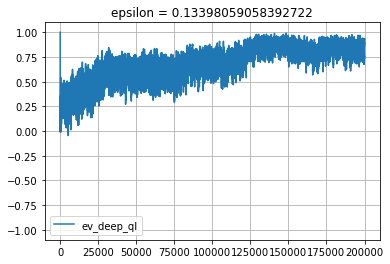

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame
import numpy as np

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(rewards_list_deep_ql[i:i+n])/n for i in range(0,len(rewards_list_deep_ql)-n+1)]

clear_output(True)
print('Deep Q-Learning mean reward =', np.mean(rewards_list_deep_ql[-1000:]))
plt.title("epsilon = %s" % epsilon)
plt.plot(moving_average(rewards_list_deep_ql), label='ev_deep_ql')
plt.grid()
plt.legend()
plt.ylim(-1.1, 1.1)
plt.show()

# Deep Q-Learning mean reward = 0.688
# Deep Q-Learning mean reward = 0.87
# Deep Q-Learning mean reward = 0.82

In [24]:
epsilon

0.13398059058392722

Loss evolution

Deep Q-Learning mean loss 1 = 0.023926833822741172


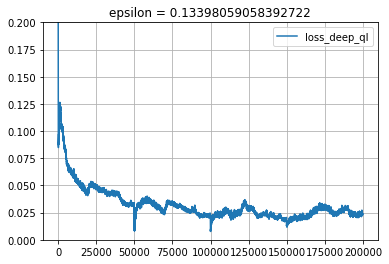

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame
import numpy as np

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(accum_train_loss[i:i+n])/n for i in range(0,len(accum_train_loss)-n+1)]

clear_output(True)
print('Deep Q-Learning mean loss 1 =', np.mean(accum_train_loss[-1000:]))
plt.title("epsilon = %s" % epsilon)
plt.plot(moving_average(accum_train_loss), label='loss_deep_ql')
plt.grid()
plt.legend()
plt.ylim(0, 0.20)
plt.show()

# Deep Q-Learning mean loss 1 = 0.032533711088239214
# Deep Q-Learning mean loss 1 = 0.02243873758718837
# Deep Q-Learning mean loss 1 = 0.023926833822741172

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame
import numpy as np

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(accum_train_loss_2[i:i+n])/n for i in range(0,len(accum_train_loss_2)-n+1)]

clear_output(True)
print('Deep Q-Learning mean loss 2 =', np.mean(accum_train_loss_2[-1000:]))
plt.title("epsilon = %s" % epsilon)
plt.plot(moving_average(accum_train_loss_2), label='loss_deep_ql')
plt.grid()
plt.legend()
plt.ylim(0, 1)
plt.show()


Save model to a file

In [26]:
model.save('model_DQN.h5')

Save list of rewards

In [27]:
with open(r'rewards_list_deep_ql.txt','w+') as f:
    for element in rewards_list_deep_ql:
        f.write(str(element) + '\n')

Save list of loss

In [13]:
with open(r'loss_list_deep_ql.txt','w+') as f:
    for element in accum_train_loss:
        f.write(str(element) + '\n')
        
with open(r'loss_2_list_deep_ql.txt','w+') as f:
    for element in accum_train_loss_2:
        f.write(str(element) + '\n')

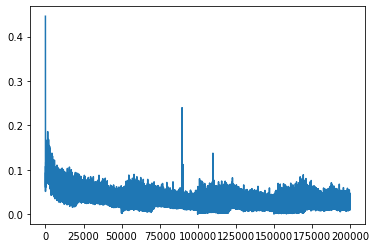

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(accum_train_loss);

Displaying kernels in Convolutional layer

In [29]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(6,)
shape of weights[0]:  (3, 3, 1, 8)
shape of weights[1]:  (8,)
shape of weights[2]:  (72, 8)
shape of weights[3]:  (8,)
shape of weights[4]:  (8, 5)
shape of weights[5]:  (5,)


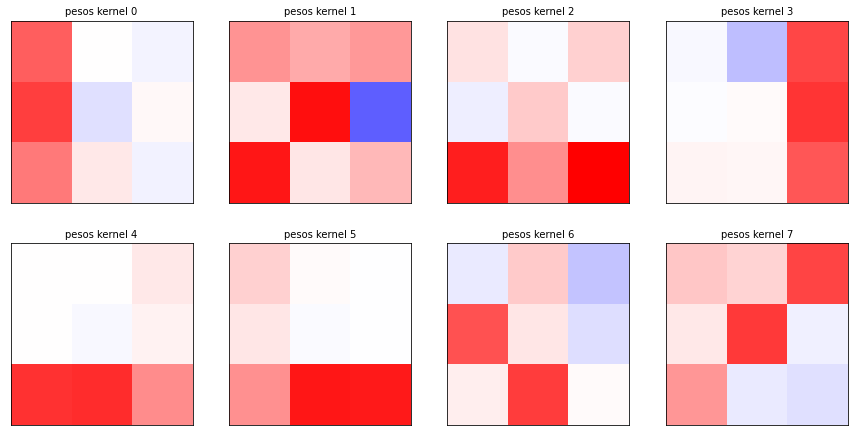

In [30]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 4 # número de columnas en la figura


ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()
for i in range(nfilters):
    kernel = weights[ncapa][:,:,0,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)
for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

Positive: 5000 Negative: 5000 Zero: 0


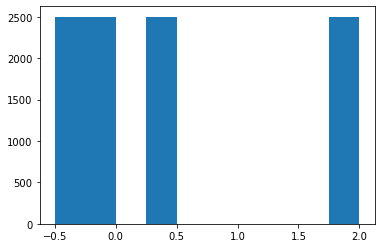

In [31]:
memory2 = memory.copy()

positive = 0
negative = 0
zero = 0
a = []
for i in memory2:
    a.append(i[2])
    if i[2] > 0:
        positive += 1
    else:
        if i[2] < 0:
            negative += 1
        else:
            zero += 1

print("Positive:", positive, "Negative:", negative, "Zero:", zero)
plt.hist(a);

In [32]:
np.unique(a, return_counts=True)

(array([-0.5  , -0.125,  0.25 ,  2.   ]),
 array([2500, 2500, 2500, 2500], dtype=int64))

Define the agent as a function, so that we can use it with Kaggle environment

In [2]:
import numpy as np
import tensorflow as tf

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_DeepQL(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    def convert_for_CNN(board, num_rows, num_cols):
        """
        Converts the board (list) into a matrix of shape (rows, cols, 1), so that a CNN can work with it.
        Player 2 checkers are replaced to -1
        """
        board = [np.float32(-1) if x==2 else np.float32(x) for x in board]
        return np.reshape(board, [1, num_rows, num_cols, 1])
    
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the model from file
    model = tf.keras.models.load_model('model_DQN.h5')
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    board_matrix = convert_for_CNN(board, num_rows, num_cols) #np.reshape(board, [1, num_rows*num_cols])
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list = [] # List of rewards of each movement
    reward_indexes_list = [] # List of indexes of each reward
    # If the agent is player 2, get the reverse board, and act as player 1
    if mark == 2:
        board_matrix = board_matrix * (-1) + 0
    q_values_list = model(board_matrix).numpy()[0]
    for target_col in available_cols:
        reward = q_values_list[target_col]
        reward_list.append(reward)
        reward_indexes_list.append(target_col)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Always get the highest reward. If the agent is player 2 we are working with the reverse board.
    max_reward = max(reward_list)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [reward_indexes_list[i] for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    return int(np.random.choice(max_rewards_index))

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_DeepQL, "random"])
env.run([agent_DeepQL, "negamax"])
#env.run(["negamax", agent_DeepQL])
#env.run(["random", agent_DeepQL])
env.render(mode="ipython", width=500, height=450)
#env.state


{'rows': 5, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
{'remainingOverageTime': 60, 'step': 0, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mark': 1}
{'rows': 5, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
{'remainingOverageTime': 60, 'step': 2, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0], 'mark': 1}
Column:0 Reward:0.18380886
Column:1 Reward:-0.055811584
Column:2 Reward:0.19777715
Column:3 Reward:-0.118466735
Column:4 Reward:0.0851478
{'rows': 5, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
{'remainingOverageTime': 60, 'step': 4, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0], 'mark': 1}
Column:0 Reward:0.20683587
Column:1 Reward:0.27731067
C

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [35]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_DeepQL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
#evaluate("connectx", ["random", agent_MQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", [agent_DeepQL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)

[[-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1],
 [-1, 1]]

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [50]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_DeepQL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_DeepQL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_DeepQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_DeepQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

My Agent vs Random Agent: 0.0
My Agent vs Negamax Agent: -1.0
Random Agent vs My Agent: 0.2
Negamax Agent vs My Agent: 1.0


In [43]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

list_agents = ["random", "negamax", agent_MC, agent_QL, agent_SA, agent_ESA, agent_MQL, agent_DQL, agent_DeepQL]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<12} {:<6}".format('Position','Agent','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<12} {:>6.2f}".format(i+1, result[0], result[1]))

# Position   Agent      Points
# 1          agent_MC     5.20
# 2          agent_MQL    4.00
# 3          negamax      3.60
# 4          agent_QL     1.60
# 5          agent_DeepQL 0.40
# 6          agent_SA    -0.60
# 7          agent_ESA   -1.00
# 8          agent_DQL   -2.20
# 9          random     -11.00

#Position   Agent        Points
#1          agent_MC       3.40
#2          agent_DeepQL   3.00
#3          agent_MQL      3.00
#4          agent_QL       2.40
#5          negamax        2.20
#6          agent_SA      -1.20
#7          agent_ESA     -1.60
#8          agent_DQL     -1.80
#9          random        -9.40

Playing random vs negamax
-0.8
Playing random vs agent_MC
-0.6
Playing random vs agent_QL
-0.6
Playing random vs agent_SA
-0.6
Playing random vs agent_ESA
0.0
Playing random vs agent_MQL
-1.0
Playing random vs agent_DQL
0.0
Playing random vs agent_DeepQL
-0.4
Playing negamax vs random
1.0
Playing negamax vs agent_MC
0.8
Playing negamax vs agent_QL
1.0
Playing negamax vs agent_SA
1.0
Playing negamax vs agent_ESA
1.0
Playing negamax vs agent_MQL
0.0
Playing negamax vs agent_DQL
1.0
Playing negamax vs agent_DeepQL
1.0
Playing agent_MC vs random
0.6
Playing agent_MC vs negamax
1.0
Playing agent_MC vs agent_QL
1.0
Playing agent_MC vs agent_SA
0.4
Playing agent_MC vs agent_ESA
1.0
Playing agent_MC vs agent_MQL
1.0
Playing agent_MC vs agent_DQL
0.8
Playing agent_MC vs agent_DeepQL
-1.0
Playing agent_QL vs random
0.8
Playing agent_QL vs negamax
1.0
Playing agent_QL vs agent_MC
1.0
Playing agent_QL vs agent_SA
0.8
Playing agent_QL vs agent_ESA
0.8
Playing agent_QL vs agent_MQL
1.0
Playing agent

#### Temporal Differece Double Deep Q-learning  
Unlike regular Deep Q-learning, in this algorithm we use 2 neural networks. One for selecting the next best action (online network), and the other one for evaluating it to update Q-values (target network). With this new Q-value we train the first neural network (the one used for selecting). Target network is periodically updated with the weights of online network. With 2 neural networks we try to avoid overestimation and underestimation.  
Off Policy. Learn policy $ \pi $ (greedy) using policy $ \mu $ (epsilon-greedy: greedy or random depending on a random value)  
Based on Hasselt's paper: https://arxiv.org/abs/1509.06461

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


rewards_list_double_deep_ql = []

ERROR! Session/line number was not unique in database. History logging moved to new session 657


Create model

In [2]:
# RED v2
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


num_cols = 5
num_rows = 5
action_size = 5

model = Sequential()
model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(num_rows, num_cols, 1))) # padding=valid # Input: (5, 5, 1) Output (3, 3, 8)
model.add(Flatten()) # Input: (3, 3, 8) Output: (72)
model.add(Dense(8, activation='relu')) # Input: (72) Output: (8)
model.add(Dense(action_size, activation="linear")) # Input: (8) Output: (5)
model.compile(Adam(lr=0.01), loss='mse')

model_target = Sequential()
model_target.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(num_rows, num_cols, 1))) # padding=valid # Input: (5, 5, 1) Output (3, 3, 8)
model_target.add(Flatten()) # Input: (3, 3, 8) Output: (72)
model_target.add(Dense(8, activation='relu')) # Input: (72) Output: (8)
model_target.add(Dense(action_size, activation="linear")) # Input: (8) Output: (5)
model_target.compile(Adam(lr=0.01), loss='mse')


ERROR! Session/line number was not unique in database. History logging moved to new session 870


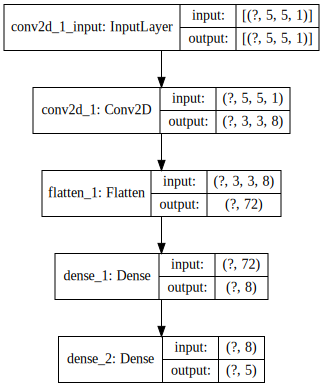

In [3]:
from IPython.display import SVG, display, clear_output
from tensorflow.keras.utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 3, 8)           80        
_________________________________________________________________
flatten_2 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 584       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________


Load model from a file

In [1]:
model = tf.keras.models.load_model('model_DDQN.h5')
model_target = tf.keras.models.load_model('model_target_DDQN.h5')

Load list of rewards

In [1]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
rewards_list_double_deep_ql = []

# open file and read the content in a list
with open('rewards_list_double_deep_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        rewards_list_double_deep_ql.append(int(currentPlace))

In [2]:
len(rewards_list_double_deep_ql)

150000

Load list of loss

In [3]:
# https://stackabuse.com/reading-and-writing-lists-to-a-file-in-python/
accum_train_loss = []

# open file and read the content in a list
with open('loss_list_double_deep_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        accum_train_loss.append(float(currentPlace))
        
accum_train_loss_2 = []

# open file and read the content in a list
with open('loss_2_list_double_deep_ql.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        accum_train_loss_2.append(float(currentPlace))

In [4]:
len(accum_train_loss), len(accum_train_loss_2)

(149862, 6395904)

Callbacks

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint


modelpath="model_DDQN_callback.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='loss', verbose=0,
                             save_best_only=True,
                             mode='min') # graba sólo los que mejoran en la función de pérdida
callbacks_list = [checkpoint]

Agent

In [6]:
import numpy as np
import random
import datetime

from kaggle_environments import make
from collections import deque

#import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

action_size = env.configuration.columns
num_cols = env.configuration.columns
num_rows = env.configuration.rows
state_size = env.configuration.columns * env.configuration.rows

# Training agent in first position (player 1) against the negamax/random agent.
#trainer = env.train([None, "negamax"])
trainer = env.train([None, "random"])

discount = 0.9
#epsilon = 0.99 # parameter for epsilon-greedy policy
#epsilon = 0.01 # parameter for epsilon-greedy policy
epsilon = 0.22089720180217606 # parameter for epsilon-greedy policy
epsilon_min = 0.05 # epsilon is decreasing but we avoid it to be smaller than epsilon_min
t_max = 1000 # used for environments without end
total_reward = 0 # used for displaying the evolution of the rewards as the model learns
memory = deque(maxlen=10000)
batch_size = 128
accum_train_loss_2 = []
#last_n_steps = 2
last_n_steps = 5
update_weights_freq = 50 # Each update_weights_freq steps we update the weights of model_target with model weights
num_episodes = 50000

#new_model = True
new_model = False
# Create/Load model
if new_model:
    model = Sequential()
    model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(num_rows, num_cols, 1))) # padding=valid # Input: (5, 5, 1) Output: (3, 3, 8)
    model.add(Flatten()) # Input: (3, 3, 8) Output: (72)
    model.add(Dense(8, activation='relu')) # Input: (72) Output: (8)
    model.add(Dense(action_size, activation="linear")) # Input: (8) Output: (5)
    model.compile(Adam(lr=0.01), loss='mse')
    
    model_target = Sequential()
    model_target.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(num_rows, num_cols, 1))) # padding=valid # Input: (5, 5, 1) Output (3, 3, 8)
    model_target.add(Flatten()) # Input: (3, 3, 8) Output: (72)
    model_target.add(Dense(8, activation='relu')) # Input: (72) Output: (8)
    model_target.add(Dense(action_size, activation="linear")) # Input: (8) Output: (5)
    model_target.compile(Adam(lr=0.01), loss='mse')
    accum_train_loss = []
    rewards_list_double_deep_ql = []
    accum_train_loss_2 = []
else:
    model = load_model('model_DDQN.h5')
    model_target = load_model('model_target_DDQN.h5')

def get_best_action(board, num_cols, model, function):
    """
    Returns the action with maximum q-value or minimum q-value depending on the needs. This will be done only in available columns
    Parameter "function" should be "max" or "min"
    """
    # function parameter validation
    if (function != "max" and function != "min"):
        print("Parameter function should be ""max"" or ""min""")
        return -1
    
    # greedy policy
    if (function == "max"):
        best_q_value = float("-inf")
    else:
        best_q_value = float("inf")
    
    # Search the best q-value but only in available columns (we cannot use np.argmax)
    best_action = None
    rewards = model(board).numpy()[0]
    available_cols = [col for col in range(num_cols) if board[0][0][col] == 0]
    for col in available_cols:
        q_value = rewards[col]
        if (function == "max" and q_value > best_q_value):
            best_action = col
            best_q_value = q_value
        else:
            if (function == "min" and q_value < best_q_value):
                best_action = col
                best_q_value = q_value
                
    return best_action

def get_action(board, num_cols, epsilon, model):
    available_cols = [col for col in range(num_cols) if board[0][0][col] == 0]
    # epison-greedy policy
    if (np.random.random() > epsilon):
        # greedy
        # We need to search best value, but only in available columns, so we cannot use np.argmax
        return get_best_action(board, num_cols, model, "max")
    else:
        # random
        return int(np.random.choice(available_cols))

def convert_for_CNN(board, num_rows, num_cols):
    """
    Converts the board (list) into a matrix of shape (rows, cols, 1), so that a CNN can work with it.
    Player 2 checkers are replaced to -1
    """
    board = [np.float32(-1) if x==2 else np.float32(x) for x in board]
    return np.reshape(board, [1, num_rows, num_cols, 1])
    
    
t = datetime.datetime.now()
print("Inicio", t.strftime("%H:%M:%S"))

obs = trainer.reset()
for i in range(num_episodes):
    done = False
    t = 0
    while not done and t < t_max:
        # Convert board in a matrix to use it as the neural network input
        board_matrix = convert_for_CNN(obs.board, num_rows, num_cols) #np.reshape(obs.board, [1, state_size])
        action = get_action(board_matrix, num_cols, epsilon, model)
        obs, reward, done, info = trainer.step(action)
        total_reward += reward
        new_board_matrix = convert_for_CNN(obs.board, num_rows, num_cols)
        
        t += 1
        
    # Train at the end of each episode

    # Add to the experience replay only the last n steps of the episode (all of them as player 1)
    num_steps = env.steps[-1][0]["observation"]["step"]
    last_reward = env.steps[-1][0]["reward"]
    for j in range(1, num_steps + 1):
        state = convert_for_CNN(env.steps[j-1][0]["observation"]["board"], num_rows, num_cols)
        next_state = convert_for_CNN(env.steps[j][0]["observation"]["board"], num_rows, num_cols)
        done = (env.steps[j][0]["status"] == 'DONE')
        # REWARD SHAPING --> As we only have reward at the end of the episode, we generate partial rewards
        if done:
            reward = last_reward * 2
        else:
            reward = (0.5 ** (num_steps - j)) * last_reward
        if env.steps[j-1][0]["status"] == 'ACTIVE':
            # Player 1
            action = env.steps[j][0]["action"]
        else:
            # Player 2 --> Convert player 2 movements into player one's
            action = env.steps[j][1]["action"]
            # Convert player 2 boards to player 1's
            state = (state * (-1)) + 0 # +0 to avoid negative zeros
            next_state = (next_state * (-1)) + 0 # +0 to avoid negative zeros
            reward = reward *(-1) + 0
        player = 1
        if (j > num_steps - last_n_steps):
            memory.append((state, action, reward, next_state, player, done))

    # Extract a minibatch from the experience replay and train the neural network
    if len(memory) > batch_size:
        minibatch = random.sample(memory, batch_size)
        
        # Create a list with the states
        state_list = [item[0] for item in minibatch]
        next_state_list = [item[3] for item in minibatch]
        
        # Convert these lists of arrays into numpy arrays
        X_states = np.concatenate(state_list, axis=0) # shape=(batch_size, num_rows, num_cols, 1)
        y_targets = np.empty(shape=(batch_size, action_size)) # shape=(batch_size, action_size)
        next_state_array = np.concatenate(next_state_list, axis=0) # shape=(batch_size, num_rows, num_cols, 1)
        
        # Predict in each network
        state_predict = model(X_states).numpy() # shape=(batch_size, action_size)
        next_state_predict = model(next_state_array).numpy() # shape=(batch_size, action_size)
        next_state_predict_target = model_target(next_state_array).numpy() # shape=(batch_size, action_size)
            
        for j, (state_batch, action_batch, reward_batch, next_state_batch, player_batch, done_batch) in enumerate(minibatch):
            X_states[j] = state_batch[0]
            model_next_qvalue = next_state_predict[j] # shape=(action_size)
            model_target_next_qvalue = next_state_predict_target[j] # shape=(action_size)
            # If it's an ending state, just update the target with the reward. If not, update target using Bellman optimality equation for Q-values
            if not done:
                target_updated = reward_batch + discount * model_target_next_qvalue[np.argmax(model_next_qvalue)]
            else:
                target_updated = reward_batch
                
            targets = state_predict[j] # shape=(action_size)
            #print("Target obtenida:", targets[0][action_batch], "Target objetivo:", target_updated)
            loss = abs(target_updated - targets[action_batch])
            accum_train_loss_2.append(loss)
            targets[action_batch] = target_updated
            y_targets[j] = targets
            
        # Train the model with these new targets
        history = model.fit(X_states, y_targets, epochs=1, callbacks=callbacks_list, verbose=0)
            
        accum_train_loss.append(history.history['loss'][0])
            
    rewards_list_double_deep_ql.append(total_reward)
    total_reward = 0
    
    # Print a summary each 500 episodes
    if (i % 500) == 0: # and len(accum_train_loss)>=10
        print("episode:", i, datetime.datetime.now().strftime("%H:%M:%S"), "avg last 10 rewards", sum(rewards_list_double_deep_ql[-10:])/10, 
              "avg last 10 loss", sum(accum_train_loss[-10:])/10, 
              "avg last 10 loss 2", sum(accum_train_loss_2[-10:])/10)
    
    # Decrease epsilon in every step so that exploration (random) is getting smaller against exploitation (greedy)
    if epsilon > epsilon_min:
        epsilon *= 0.99999
        
    obs = trainer.reset()

    # Update target network weights each update_weights_freq steps
    if (i % update_weights_freq) == 0 and len(memory) > batch_size and i > 0:
        model_weights = model.get_weights()
        model_target.set_weights(model_weights)

    if (i % 10000) == 0 and i > 0:
        print(i, datetime.datetime.now().strftime("%H:%M:%S"))

    if (i % 20000) == 0 and i > 0:
        last_n_steps += 1
        

t = datetime.datetime.now()
print("Fin", t.strftime("%H:%M:%S"))



# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 50.000
# 00:34:20
# 01:49:19
# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 100.000
# 12:25:53
# 14:18:40
# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 150.000 <--- MEJOR RESULTADO
# 14:51:29
# 16:40:06
# 50000 CNN random, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 200.000
# 11:54:01
# 13:08:28

# 50000 CNN negamax, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 50.000
# 15:11:49
# 17:45:53
# 50000 CNN negamax, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 100.000
# 19:41:24
# 22:14:12
# 50000 CNN negamax, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 150.000
# 22:39:31
# 01:18:11
# 50000 CNN negamax, fit con todo el minibatch (Local) solo los n pasos finales (todos como jugador 1) # 200.000
# 20:38:57
# 23:44:46

Loading environment football failed: No module named 'gfootball'
Inicio 11:54:01
episode: 0 11:54:01 avg last 10 rewards 0.8 avg last 10 loss 0.015508028771728277 avg last 10 loss 2 0.0
episode: 500 11:54:42 avg last 10 rewards 1.0 avg last 10 loss 0.014209338673390448 avg last 10 loss 2 0.12167543172836304
episode: 1000 11:55:22 avg last 10 rewards 0.8 avg last 10 loss 0.01339363430161029 avg last 10 loss 2 0.14353678822517396
episode: 1500 11:56:05 avg last 10 rewards 0.8 avg last 10 loss 0.012571645725984126 avg last 10 loss 2 0.08356679677963257
episode: 2000 11:56:52 avg last 10 rewards 0.6 avg last 10 loss 0.0145413130056113 avg last 10 loss 2 0.38711132705211637
episode: 2500 11:57:42 avg last 10 rewards 1.0 avg last 10 loss 0.011858548317104579 avg last 10 loss 2 0.08449787497520447
episode: 3000 11:58:22 avg last 10 rewards 1.0 avg last 10 loss 0.014915959525387735 avg last 10 loss 2 0.10784176588058472
episode: 3500 11:59:07 avg last 10 rewards 0.8 avg last 10 loss 0.01486861

In [7]:
import numpy as np


np.unique(rewards_list_double_deep_ql, return_counts=True)
# (array([-1,  1]), array([12595, 37405], dtype=int64))
# (array([-1,  1]), array([19389, 80611], dtype=int64))
# (array([-1,  1]), array([ 23248, 126752], dtype=int64))
# (array([-1,  1]), array([ 25977, 174023], dtype=int64))

# (array([-1,  1]), array([47765,  2235], dtype=int64))
# (array([-1,  1]), array([95603,  4397], dtype=int64))
# (array([-1,  1]), array([142004,   7996], dtype=int64))
# (array([-1,  1]), array([190031,   9969], dtype=int64))

(array([-1,  1]), array([ 25977, 174023], dtype=int64))

Rewards evolution

Double Deep Q-Learning mean reward = 0.904


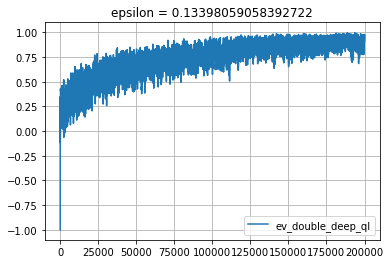

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame
import numpy as np

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(rewards_list_double_deep_ql[i:i+n])/n for i in range(0,len(rewards_list_double_deep_ql)-n+1)]

clear_output(True)
print('Double Deep Q-Learning mean reward =', np.mean(rewards_list_double_deep_ql[-1000:]))
plt.title("epsilon = %s" % epsilon)
plt.plot(moving_average(rewards_list_double_deep_ql), label='ev_double_deep_ql')
plt.grid()
plt.legend()
plt.ylim(-1.1, 1.1)
plt.show()

# Double Deep Q-Learning mean reward = 0.62
# Double Deep Q-Learning mean reward = 0.792
# Double Deep Q-Learning mean reward = 0.896
# Double Deep Q-Learning mean reward = 0.904

# Double Deep Q-Learning mean reward = -0.916
# Double Deep Q-Learning mean reward = -0.848
# Double Deep Q-Learning mean reward = -0.926
# Double Deep Q-Learning mean reward = -0.956

In [9]:
epsilon

0.13398059058392722

In [26]:
len(accum_train_loss)

49936

In [28]:
len(memory)

10000

Loss evolution

Double Deep Q-Learning mean loss 1 = 0.01345655702817021


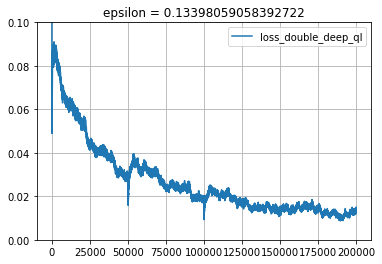

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame
import numpy as np

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(accum_train_loss[i:i+n])/n for i in range(0,len(accum_train_loss)-n+1)]

clear_output(True)
print('Double Deep Q-Learning mean loss 1 =', np.mean(accum_train_loss[-1000:]))
plt.title("epsilon = %s" % epsilon)
plt.plot(moving_average(accum_train_loss), label='loss_double_deep_ql')
plt.grid()
plt.legend()
plt.ylim(0, 0.1)
plt.show()

# Double Deep Q-Learning mean loss 1 = 0.029851529055216815
# Double Deep Q-Learning mean loss 1 = 0.01879366305511212
# Double Deep Q-Learning mean loss 1 = 0.013116003537375945
# Double Deep Q-Learning mean loss 1 = 0.01345655702817021

# Double Deep Q-Learning mean loss 1 = 0.02545835962938145
# Double Deep Q-Learning mean loss 1 = 0.015763490679324605
# Double Deep Q-Learning mean loss 1 = 0.01234157059469726
# Double Deep Q-Learning mean loss 1 = 0.00909327546262648

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from pandas import DataFrame
import numpy as np

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
# ewm --> Weighted average of the values from x0 to xt. The weight of each element is decreasing from xt (weight=1) to xt-n (weight=(1-alpha)^n). alpha=2/(span+1)=2/101
# This function gives us the trend of the rewards, instead of a sharp graph with a lot of -1's and 1's
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

# Displaying the average of n elemtens instead of each element of the list 
n = 1000
moving_average2 = [sum(accum_train_loss_2[i:i+n])/n for i in range(0,len(accum_train_loss_2)-n+1)]

clear_output(True)
print('Deep Q-Learning mean loss 2 =', np.mean(accum_train_loss_2[-1000:]))
plt.title("epsilon = %s" % epsilon)
plt.plot(moving_average(accum_train_loss_2), label='loss_deep_ql')
plt.grid()
plt.legend()
plt.ylim(0, 1)
plt.show()


Save model to a file

In [11]:
model.save('model_DDQN.h5')
model_target.save('model_target_DDQN.h5')

Save list of rewards

In [12]:
with open(r'rewards_list_double_deep_ql.txt','w+') as f:
    for element in rewards_list_double_deep_ql:
        f.write(str(element) + '\n')

Save list of loss

In [13]:
with open(r'loss_list_double_deep_ql.txt','w+') as f:
    for element in accum_train_loss:
        f.write(str(element) + '\n')
        
with open(r'loss_2_list_double_deep_ql.txt','w+') as f:
    for element in accum_train_loss_2:
        f.write(str(element) + '\n')

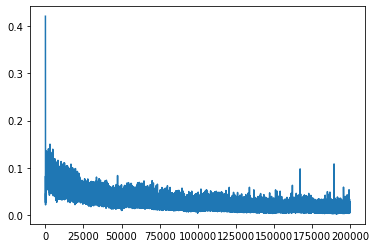

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(accum_train_loss);

Displaying kernels in Convolutional layer

In [15]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(6,)
shape of weights[0]:  (3, 3, 1, 8)
shape of weights[1]:  (8,)
shape of weights[2]:  (72, 8)
shape of weights[3]:  (8,)
shape of weights[4]:  (8, 5)
shape of weights[5]:  (5,)


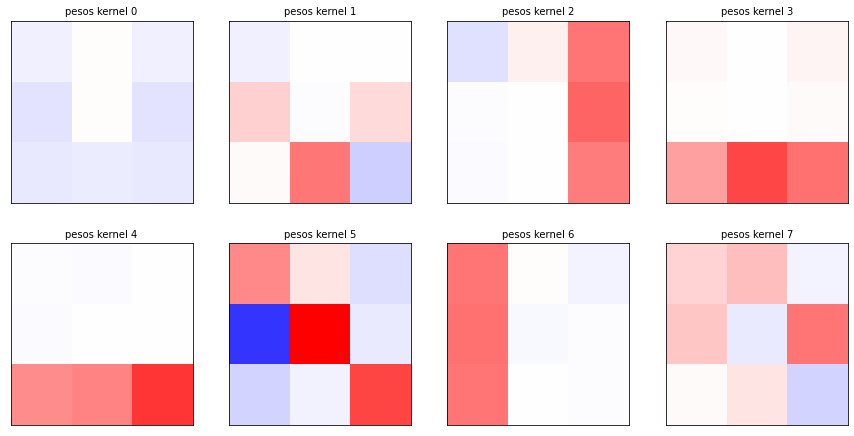

In [16]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 4 # número de columnas en la figura


ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()
for i in range(nfilters):
    kernel = weights[ncapa][:,:,0,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)
for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

Negative: 4164 Zero: 0 Positive: 5836


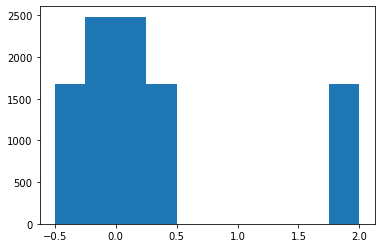

In [17]:
memory2 = memory.copy()

positive = 0
negative = 0
zero = 0
a = []
for i in memory2:
    a.append(i[2])
    if i[2] > 0:
        positive += 1
    else:
        if i[2] < 0:
            negative += 1
        else:
            zero += 1

print("Negative:", negative, "Zero:", zero, "Positive:", positive)
plt.hist(a);

In [18]:
np.unique(a, return_counts=True)

(array([-0.5     , -0.125   , -0.03125 ,  0.015625,  0.0625  ,  0.25    ,
         2.      ]),
 array([1680, 1680,  804,  796, 1680, 1680, 1680], dtype=int64))

Define the agent as a function, so that we can use it with Kaggle environment

In [7]:
import numpy as np
import tensorflow as tf

from kaggle_environments import make


env = make("connectx", {"rows": 5, "columns": 5, "inarow": 3}, debug=True)

def agent_Double_DeepQL(observation, configuration):
    
    ################################## START NESTED FUNCTIONS ###########################################
    
    # Given a board (as a list) and a column, returns the index of the first row available
    def first_row_avail(board, col, num_rows, num_cols):
        """
        Given a board (as a list) and a column, returns the index of the first row available
        """
        index = -1
        for i in range(num_rows): # from top to bottom
            board_index = col + (i * num_cols)
            if board[board_index] == 0:
                index = board_index
            else:
                return index
        return index
            
    def convert_for_CNN(board, num_rows, num_cols):
        """
        Converts the board (list) into a matrix of shape (rows, cols, 1), so that a CNN can work with it.
        Player 2 checkers are replaced to -1
        """
        board = [np.float32(-1) if x==2 else np.float32(x) for x in board]
        return np.reshape(board, [1, num_rows, num_cols, 1])
    
    ################################## END NESTED FUNCTIONS ###########################################
    
    print(configuration) # {rows: 5, columns: 5, inarow: 3}
    # Number of rows on the board
    num_rows = configuration.rows
    # Number of columns on the board
    num_cols = configuration.columns
    # Number of checkers "in a row" needed to win
    in_a_row = configuration.inarow
    print(observation) # {board: [...], mark: 1}
    # The current serialized board (rows x columns) - array [rows x columns] with top row first
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    # If the board is empty, put the first checker in the middle column
    if max(board)==0:
        return round(num_cols/2)
    
    # Load the model from file
    model = tf.keras.models.load_model('model_DDQN.h5')
    # List of available columns
    available_cols = [col for col in range(num_cols) if board[col] == 0]
    # Convert the list board into a two-dimensional array
    board_matrix = convert_for_CNN(board, num_rows, num_cols) #np.reshape(board, [1, num_rows*num_cols])
    # Evaluate the target board with a checker in each available column, and get the best one
    reward_list = [] # List of rewards of each movement
    reward_indexes_list = [] # List of indexes of each reward
    # If the agent is player 2, get the reverse board, and act as player 1
    if mark == 2:
        board_matrix = board_matrix * (-1) + 0
    q_values_list = model(board_matrix).numpy()[0]
    for target_col in available_cols:
        reward = q_values_list[target_col]
        reward_list.append(reward)
        reward_indexes_list.append(target_col)
        print("Column:"+str(target_col)+" Reward:"+str(reward))
    # Always get the highest reward. If the agent is player 2 we are working with the reverse board.
    max_reward = max(reward_list)
    # Return the column with the highest reward. If several actions have the same reward, select randomly one of them
    max_rewards_index = [reward_indexes_list[i] for i, x in enumerate(reward_list) if x == max_reward]
    # Check if max_rewards_index is empty (every value is zero or almost 1). In this case take a column randomly
    if max_rewards_index == []:
        max_rewards_index = available_cols
    return int(np.random.choice(max_rewards_index))

# Run an episode using the agent above vs the negamax agent.
#env.run([agent_Double_DeepQL, "random"])
env.run([agent_Double_DeepQL, "negamax"])
#env.run(["negamax", agent_Double_DeepQL])
#env.run(["negamax", agent_DeepQL])
#env.run(["random", agent_DeepQL])
env.render(mode="ipython", width=500, height=450)
#env.state


{'rows': 5, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
{'remainingOverageTime': 60, 'step': 0, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mark': 1}
{'rows': 5, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
{'remainingOverageTime': 60, 'step': 2, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0], 'mark': 1}
Column:0 Reward:-0.117846906
Column:1 Reward:0.06508827
Column:2 Reward:0.17722237
Column:3 Reward:0.04854679
Column:4 Reward:-0.0121792555
{'rows': 5, 'columns': 5, 'inarow': 3, 'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'agentTimeout': 60, 'timeout': 2}
{'remainingOverageTime': 60, 'step': 4, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0], 'mark': 1}
Column:0 Reward:-0.121901214
Column:1 Reward:-0.04552

The function 'evaluate' returns a list of lists (one list per episode).  
These lists per episode contains two elements (one per player), and these elements have these possible values:
- 1: This player wins
- -1: This player loses
- 0: Draw (I guess there will be a value for draw)  
Example:  
[[1, -1], # First episode: Player 1 won  
 [1, -1], # Second episode: Player 1 won  
 [1, -1], # Third episode: Player 1 won  
 [1, -1], # ...  
 [1, -1],  
 [1, -1],  
 [-1, 1],  
 [1, -1],  
 [1, -1],  
 [-1, 1]]

In [ ]:
from kaggle_environments import evaluate
help(evaluate)

In [23]:
from kaggle_environments import evaluate

#evaluate("connectx", [agent_DeepQL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
#evaluate("connectx", ["random", agent_MQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
#evaluate("connectx", [agent_Double_DeepQL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", [agent_Double_DeepQL_nega, agent_Double_DeepQL_rand], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)
evaluate("connectx", [agent_Double_DeepQL_rand, agent_Double_DeepQL_nega], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)

[[1, -1],
 [1, -1],
 [1, -1],
 [1, -1],
 [1, -1],
 [1, -1],
 [1, -1],
 [1, -1],
 [1, -1],
 [1, -1]]

Test our agent against random and negamax agent.  
- The closer the value is to 1 the better is player 1 agent (wins more times than loses)
- The closer the value is to -1 the worse is player 1 agent (loses more times than wins)

In [50]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_DeepQL, "random"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_DeepQL, "negamax"], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", agent_DeepQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))
print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", agent_DeepQL], configuration={"rows": 5, "columns": 5, "inarow": 3}, num_episodes=10)))

My Agent vs Random Agent: 0.0
My Agent vs Negamax Agent: -1.0
Random Agent vs My Agent: 0.2
Negamax Agent vs My Agent: 1.0


In [29]:
# https://docs.python.org/3/library/itertools.html
from itertools import permutations
from kaggle_environments import evaluate


def name(obj):
    """
    If obj is a function, gets the name instead of something like <function agent_MC at 0x0000023B01C3C950>
    """
    if callable(obj):
        return getattr(obj, "__name__")
    else:
        return obj

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))
    
conf={"rows": 5, "columns": 5, "inarow": 3}

#list_agents = ["random", "negamax", agent_MC, agent_QL, agent_SA, agent_ESA, agent_MQL, agent_DQL, agent_DeepQL, agent_Double_DeepQL]
list_agents = ["negamax", agent_MC, agent_MQL, agent_DeepQL, agent_Double_DeepQL]
list_matches = list(permutations(list_agents, 2))
results = {}

for players in list_matches:
    print("Playing", name(players[0]), "vs", name(players[1]))
    list_players = list(players)
    result = mean_reward(evaluate("connectx", agents=list_players, configuration=conf, num_episodes=10))
    print(result)
    results[name(players[0])] = results.get(name(players[0]), 0) + result
    results[name(players[1])] = results.get(name(players[1]), 0) - result

print(results)

# Display results ordered by the points obtained
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("{:<10} {:<20} {:<6}".format('Position','Agent','Points')) # https://docs.python.org/3/library/string.html#formatspec
for i, result in enumerate(sorted_results):
    print("{:<10} {:<20} {:>6.2f}".format(i+1, result[0], result[1]))

#Position   Agent                Points
#1          agent_MQL              3.00
#2          agent_MC               2.00
#3          negamax                1.80
#4          agent_DeepQL          -1.80
#5          agent_Double_DeepQL   -5.00


Playing negamax vs agent_MC
1.0
Playing negamax vs agent_MQL
0.2
Playing negamax vs agent_DeepQL
1.0
Playing negamax vs agent_Double_DeepQL
1.0
Playing agent_MC vs negamax
1.0
Playing agent_MC vs agent_MQL
1.0
Playing agent_MC vs agent_DeepQL
-1.0
Playing agent_MC vs agent_Double_DeepQL
1.0
Playing agent_MQL vs negamax
1.0
Playing agent_MQL vs agent_MC
1.0
Playing agent_MQL vs agent_DeepQL
0.2
Playing agent_MQL vs agent_Double_DeepQL
0.0
Playing agent_DeepQL vs negamax
0.4
Playing agent_DeepQL vs agent_MC
-1.0
Playing agent_DeepQL vs agent_MQL
-1.0
Playing agent_DeepQL vs agent_Double_DeepQL
1.0
Playing agent_Double_DeepQL vs negamax
-1.0
Playing agent_Double_DeepQL vs agent_MC
-1.0
Playing agent_Double_DeepQL vs agent_MQL
-1.0
Playing agent_Double_DeepQL vs agent_DeepQL
1.0
{'negamax': 1.8000000000000003, 'agent_MC': 2.0, 'agent_MQL': 3.0, 'agent_DeepQL': -1.8, 'agent_Double_DeepQL': -5.0}
Position   Agent                Points
1          agent_MQL              3.00
2          agent_M